In [1]:
%config InlineBackend.figure_format = 'retina'

In [2]:
import os
import re
import anndata as ad
import numpy as np
import pandas as pd
import scanpy as sc
from glob import glob
from copy import deepcopy
import pyranges as pr
import infercnvpy as cnv
from statannotations.Annotator import Annotator
from sklearn.metrics import auc, roc_auc_score, roc_curve
from scipy.stats import pearsonr, chi2_contingency, linregress, ranksums, spearmanr
from collections import Counter
import matplotlib.pyplot as plt
from matplotlib_venn import venn2, venn2_circles, venn3
import matplotlib as mpl
import seaborn as sns

import matplotlib as mpl
mpl.rcParams['pdf.fonttype'] = 42
from matplotlib import font_manager

In [3]:
label_dict = {'Normal':0,'Tumor':1}

In [4]:
sns.set_style('ticks')

In [5]:
method_color_dict = {'scMalignantFinder':"#E53935", 'PreCanCell':"#1E88E5", 'ikarus':'#43A047'}

In [6]:
group_colors = [
    "#E53935", "#1E88E5", "#FFB300", "#43A047", "#9B26B0", "#3F51B4", "#02A9F3", "#00BBD3", "#009687", "#8BC34A",
    "#CCDC39", "#FFEB3A", "#FF9800", "#FF5721", "#795447", "#5F7D8B", "#E57272", "#F06192", "#B967C7", "#7985CB",
    "#4EC3F7", "#4CD0E0", "#4CB6AC", "#ADD480", "#DCE674", "#FFF176", "#FFB74C", "#FF8A65", "#A0877F", "#90A4AD",
    "#C52727", "#AC1357", "#6A1A99", "#273492", "#0177BD", "#00838E", "#00685B", "#548B2E", "#9E9D24", "#F8A725",
    "#EE6C00", "#D84314", "#4D332D", "#37464E", "#EE9999", "#F38EB1", "#CD92D8", "#9FA7D9", "#80D3F9", "#7FDEEA",
    "#7FCBC4", "#C5E0A5", "#E5ED9B", "#FFF49D", "#FFCC7F", "#FFAB91", "#BBAAA4", "#B0BEC5", "#FF6E00", "#202020",
    "#1A5E1F", "#311A92", "#FFC006", "#9E9E9E", "#4CAE50", "#6639B7", "#FFD44E", "#DFDFDF", "#80C684", "#9474CC",
    "#FF9F00", "#606060", "#388D3B", "#512CA7", "#FFDF81", "#EDEDED", "#A5D6A6", "#B29DDA", "#FFF8E0", "#F9F9F9"]

In [7]:
sc.settings.set_figure_params(figsize=(5,5), dpi=100, facecolor='white')

In [8]:
os.chdir('/mnt/home/qnyu/workspace/scOmics/malignantModel/multi_tissue')

In [9]:
up_genesets = ['Invasion','Genome Instability and Mutation','DNA_damage','Resisting Cell Death',
              'Cell_Cycle','Enabling Replicative Immortality','DNA_repair','Evading Growth Suppressors']
down_genesets = ['Normal-enriched (S02)']

sel_genesets = up_genesets+down_genesets

In [10]:
test_prefixs = ['LC2','LC3','CRC1','CRC2','HCC']
test_adata_dict = {}
test_plot_dict = {}
for prefix in test_prefixs:
    if prefix == 'cellLineTabula':
        adata = sc.read_h5ad(f'./data/test_{prefix}.h5ad')
        adata.obs = pd.concat([adata.obs,refine_meta_df], axis=1)
    else:
        adata = sc.read_h5ad(f'./data/test_{prefix}.h5ad')
    test_gene_df = pd.read_csv(f'./file/prediction/test_{prefix}.gene.tsv', sep='\t', index_col=0)
    adata.obs['Prediction'] = test_gene_df.loc[adata.obs_names,'LR']
    adata.obs['Predicted_annotation'] = 'True Tumor'
    adata.obs.loc[(adata.obs['Raw_annotation']==adata.obs['Prediction']) & (adata.obs['Raw_annotation']=='Normal'), 'Predicted_annotation'] = 'True Normal'
    adata.obs.loc[(adata.obs['Raw_annotation']!=adata.obs['Prediction']) & (adata.obs['Raw_annotation']=='Normal'), 'Predicted_annotation'] = 'False Tumor'
    adata.obs.loc[(adata.obs['Raw_annotation']!=adata.obs['Prediction']) & (adata.obs['Raw_annotation']=='Tumor'), 'Predicted_annotation'] = 'False Normal'
    
    plot_df = pd.melt(adata.obs[['Predicted_annotation']+sel_genesets], id_vars=['Predicted_annotation'], 
                      value_vars=sel_genesets)
    test_plot_dict[prefix] = plot_df
    
    test_adata_dict[prefix] = adata

In [11]:
pairs = []
for geneset in sel_genesets:
    pairs.append(((geneset,'False Tumor'),(geneset,'True Normal')))
    pairs.append(((geneset,'False Normal'),(geneset,'True Tumor')))

INFO:fontTools.subset:maxp pruned
INFO:fontTools.subset:cmap pruned
INFO:fontTools.subset:kern dropped
INFO:fontTools.subset:post pruned
INFO:fontTools.subset:FFTM dropped
INFO:fontTools.subset:GPOS pruned
INFO:fontTools.subset:GSUB pruned
INFO:fontTools.subset:name pruned
INFO:fontTools.subset:glyf pruned
INFO:fontTools.subset:Added gid0 to subset
INFO:fontTools.subset:Added first four glyphs to subset
INFO:fontTools.subset:Closing glyph list over 'GSUB': 56 glyphs before
INFO:fontTools.subset:Glyph names: ['.notdef', '.null', 'A', 'C', 'D', 'E', 'F', 'G', 'I', 'L', 'M', 'N', 'R', 'S', 'T', 'U', 'a', 'asterisk', 'b', 'c', 'comma', 'd', 'e', 'eight', 'equal', 'five', 'four', 'g', 'h', 'hyphen', 'i', 'l', 'm', 'n', 'nine', 'nonmarkingreturn', 'o', 'one', 'p', 'parenleft', 'parenright', 'period', 'r', 's', 'seven', 'six', 'space', 't', 'three', 'two', 'u', 'underscore', 'v', 'w', 'y', 'zero']
INFO:fontTools.subset:Glyph IDs:   [0, 1, 2, 3, 11, 12, 13, 15, 16, 17, 19, 20, 21, 22, 23, 24, 

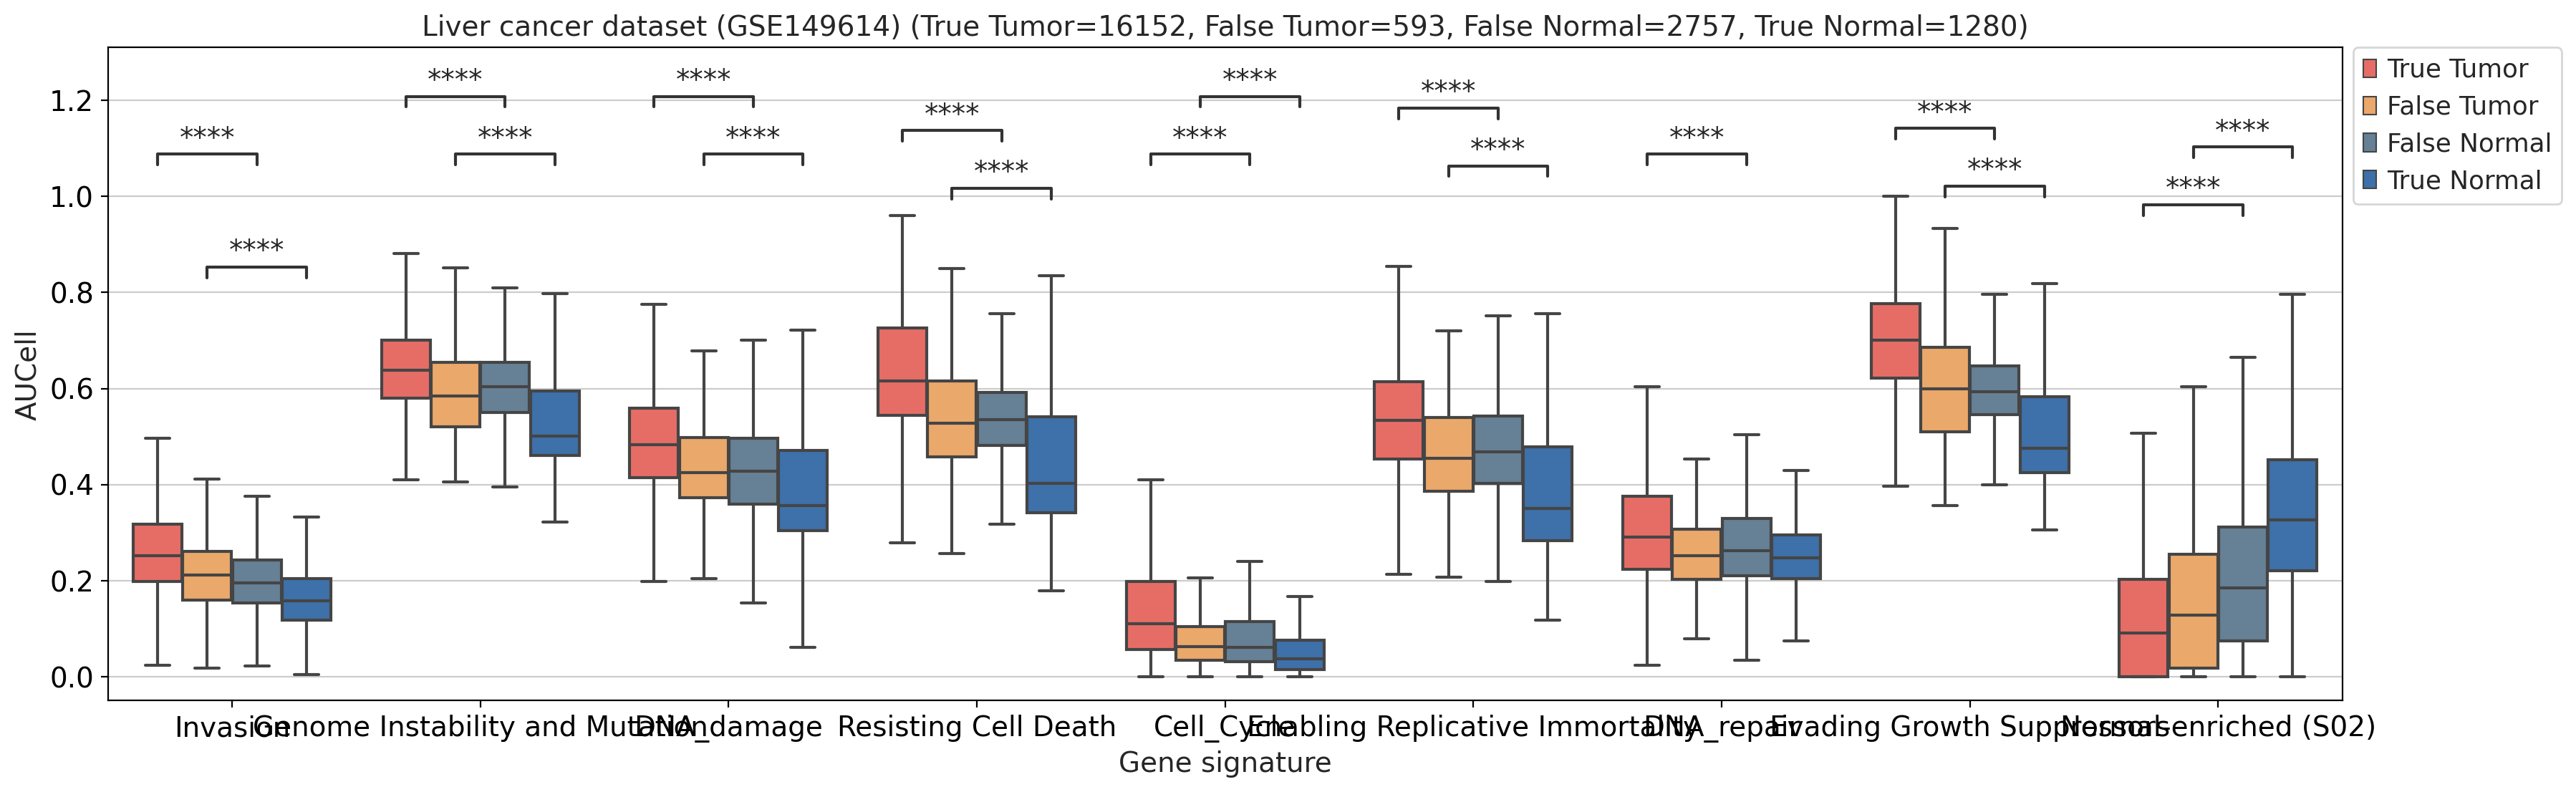

In [12]:
prefix = 'HCC'
title = 'Liver cancer dataset (GSE149614)'
plot_df = test_plot_dict[prefix]
plt.figure(figsize=(20,6))
ax = sns.boxplot(x='variable', y='value', hue='Predicted_annotation', data=plot_df, palette=['#fc5a50','#ffa756','#5e819d','#2c6fbb'], 
                 hue_order=['True Tumor','False Tumor','False Normal','True Normal'], fliersize=0)
_ = plt.xlabel('Gene signature')
_ = plt.ylabel('AUCell')
nb_true_tumor = (adata.obs['Predicted_annotation']=='True Tumor').sum()
nb_false_tumor = (adata.obs['Predicted_annotation']=='False Tumor').sum()
nb_true_normal = (adata.obs['Predicted_annotation']=='True Normal').sum()
nb_false_normal = (adata.obs['Predicted_annotation']=='False Normal').sum()
_ = plt.title('{0} (True Tumor={1}, False Tumor={2}, False Normal={3}, True Normal={4})'.format(title, nb_true_tumor, nb_false_tumor, nb_false_normal, nb_true_normal))
annot = Annotator(ax, pairs, x='variable', y='value', hue='Predicted_annotation', data=plot_df, hue_order=['True Tumor','False Tumor','False Normal','True Normal'], hide_non_significant=True)
annot.configure(test='t-test_ind', text_format='star', verbose=0)
annot.apply_test()
annot.annotate()
plt.legend(bbox_to_anchor=(1.005, 1), loc='upper left', borderaxespad=0)
_ = plt.xlim([-0.5,8.5])
plt.savefig(f'./plot/cancer_hallmarks_{prefix}_four_categories.boxplot.pdf', bbox_inches='tight')

In [13]:
adata = test_adata_dict[prefix]

In [14]:
gr = pr.read_gtf("/mnt/home/qnyu/reference/cellranger/genes.hg38.gtf")
ref_df = gr.df[gr.df['Feature']=='gene']

/mnt/home/qnyu/miniconda3/envs/scverse/lib/python3.10/site-packages/pyranges/methods/init.py:58: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  return {k: v for k, v in df.groupby(grpby_key)}


In [15]:
sc.pp.normalize_total(adata, target_sum=1e4)
sc.pp.log1p(adata)

overlap_genes = list(set(adata.var_names) & set(ref_df['gene_name']))
print(len(overlap_genes))

spec_gene_dict = {
    'GOLGA8M':'1957781','MATR3':'801455','ARMCX5-GPRASP2':'2699327','LINC01238':'353646','TMSB15B':'2700269','HSPA14':'1341394',
    'LINC01505':'1265639','CYB561D2':'493710','GGT1':'2621672','TBCE':'129239'
}

unique_ref_df = ref_df[ref_df['gene_name'].isin(ref_df['gene_name'].value_counts()[ref_df['gene_name'].value_counts()==1].index)]
double_ref_df = ref_df[ref_df['gene_name'].isin(ref_df['gene_name'].value_counts()[ref_df['gene_name'].value_counts()==2].index)]
unique_double_ref_df = double_ref_df.loc[[int(x) for x in list(spec_gene_dict.values())]]

concat_ref_df = pd.concat([unique_ref_df,unique_double_ref_df])
concat_ref_df.index = concat_ref_df['gene_name'].tolist()

concat_ref_df = concat_ref_df.loc[overlap_genes]

adata = adata[:,overlap_genes].copy()

adata.var['chromosome'] = concat_ref_df['Chromosome'].tolist()
adata.var['end'] = concat_ref_df['Start'].tolist()
adata.var['start'] = concat_ref_df['End'].tolist()

19011


In [16]:
cnv.tl.infercnv(
        adata,
        reference_key='Raw_annotation',
        reference_cat=['Normal'],
        window_size=250,
        exclude_chromosomes=['chrX','chrY'],
        chunksize=1000,
        n_jobs=20,
        inplace=True
)

cnv.tl.pca(adata)
cnv.pp.neighbors(adata)

  0%|          | 0/21 [00:00<?, ?it/s]

/mnt/home/qnyu/miniconda3/envs/scverse/lib/python3.10/site-packages/anndata/_core/anndata.py:117: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)
... storing 'Predicted_annotation' as categorical


         Falling back to preprocessing with `sc.pp.pca` and default params.
categories: False Normal, False Tumor, True Normal, etc.
var_group_labels: chr1, chr2, chr3, etc.


/mnt/home/qnyu/miniconda3/envs/scverse/lib/python3.10/site-packages/scanpy/tools/_dendrogram.py:133: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  mean_df = rep_df.groupby(level=0).mean()
INFO:fontTools.subset:maxp pruned
INFO:fontTools.subset:cmap pruned
INFO:fontTools.subset:kern dropped
INFO:fontTools.subset:post pruned
INFO:fontTools.subset:FFTM dropped
INFO:fontTools.subset:GPOS pruned
INFO:fontTools.subset:GSUB pruned
INFO:fontTools.subset:name pruned
INFO:fontTools.subset:glyf pruned
INFO:fontTools.subset:Added gid0 to subset
INFO:fontTools.subset:Added first four glyphs to subset
INFO:fontTools.subset:Closing glyph list over 'GSUB': 35 glyphs before
INFO:fontTools.subset:Glyph names: ['.notdef', '.null', 'F', 'N', 'P', 'T', 'a', 'c', 'd', 'e', 'eight', 'five', 'four', 'h', 'i', 'l', 'm', '

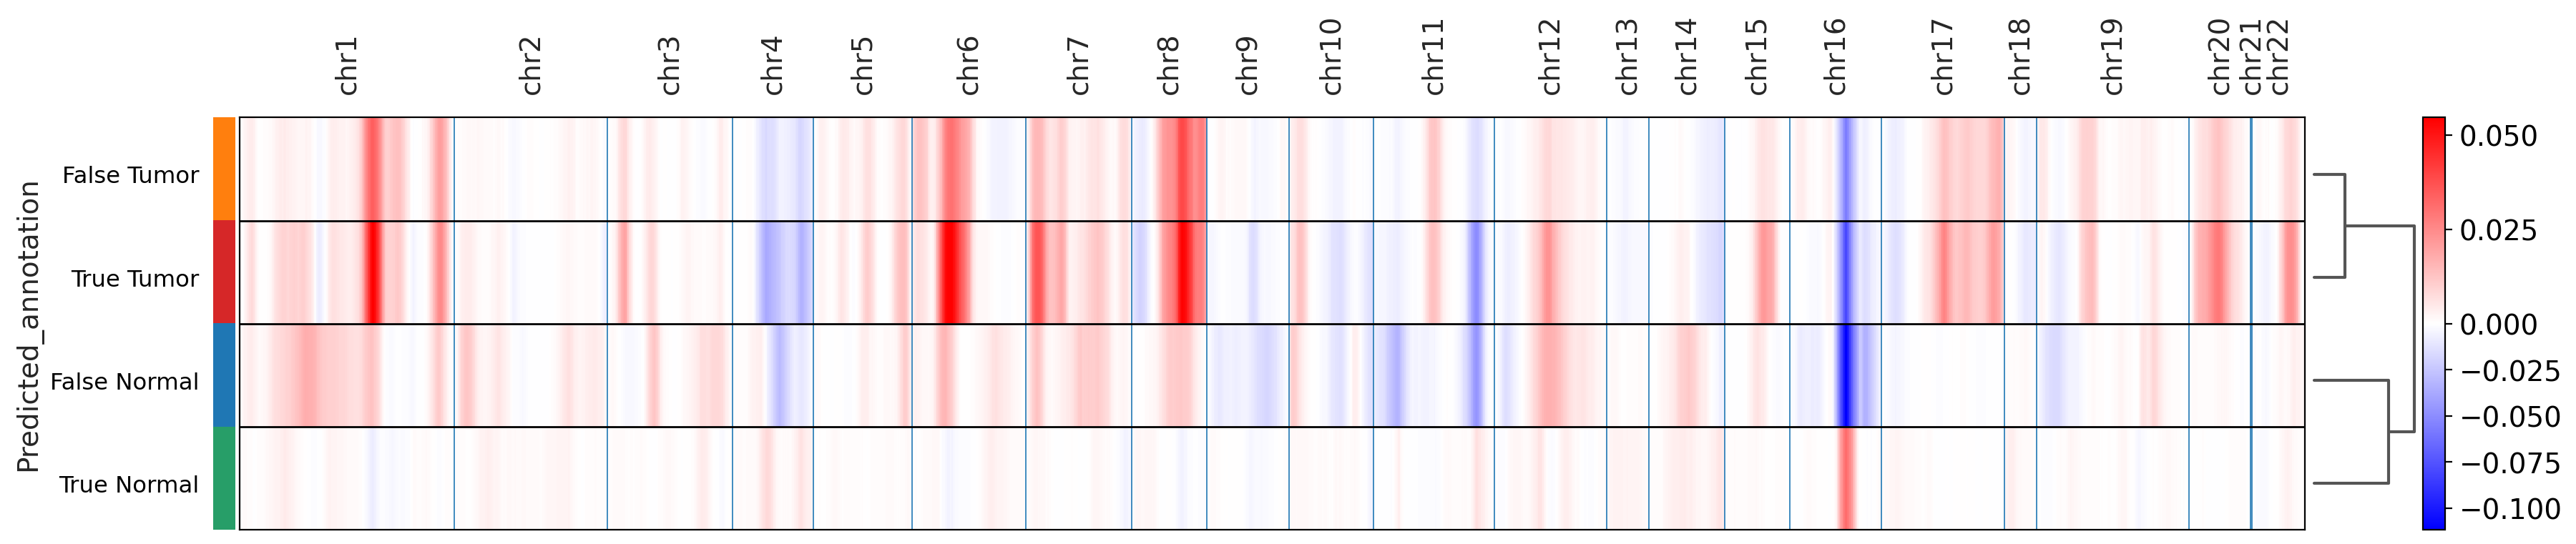

In [17]:
zdict = cnv.pl.chromosome_heatmap_summary(adata, groupby="Predicted_annotation", dendrogram=True, show=False, figsize=(20,4))
# _ = plt.xticks(rotation=90)
plt.savefig(f'./plot/infercnv_{prefix}_four_categories.heatmap.pdf', bbox_inches='tight')

In [18]:
cnv.tl.leiden(adata, resolution=1.5)
cnv.tl.cnv_score(adata)

In [19]:
pairs = [('True Normal','False Tumor'),('True Tumor','False Normal')]

INFO:fontTools.subset:maxp pruned
INFO:fontTools.subset:cmap pruned
INFO:fontTools.subset:kern dropped
INFO:fontTools.subset:post pruned
INFO:fontTools.subset:FFTM dropped
INFO:fontTools.subset:GPOS pruned
INFO:fontTools.subset:GSUB pruned
INFO:fontTools.subset:name pruned
INFO:fontTools.subset:glyf pruned
INFO:fontTools.subset:Added gid0 to subset
INFO:fontTools.subset:Added first four glyphs to subset
INFO:fontTools.subset:Closing glyph list over 'GSUB': 30 glyphs before
INFO:fontTools.subset:Glyph names: ['.notdef', '.null', 'F', 'N', 'P', 'T', 'a', 'asterisk', 'c', 'd', 'e', 'five', 'i', 'l', 'm', 'n', 'nonmarkingreturn', 'o', 'one', 'period', 'r', 's', 'seven', 'space', 't', 'two', 'u', 'underscore', 'v', 'zero']
INFO:fontTools.subset:Glyph IDs:   [0, 1, 2, 3, 13, 17, 19, 20, 21, 24, 26, 41, 49, 51, 55, 66, 68, 70, 71, 72, 76, 79, 80, 81, 82, 85, 86, 87, 88, 89]
INFO:fontTools.subset:Closed glyph list over 'GSUB': 30 glyphs after
INFO:fontTools.subset:Glyph names: ['.notdef', '.nu

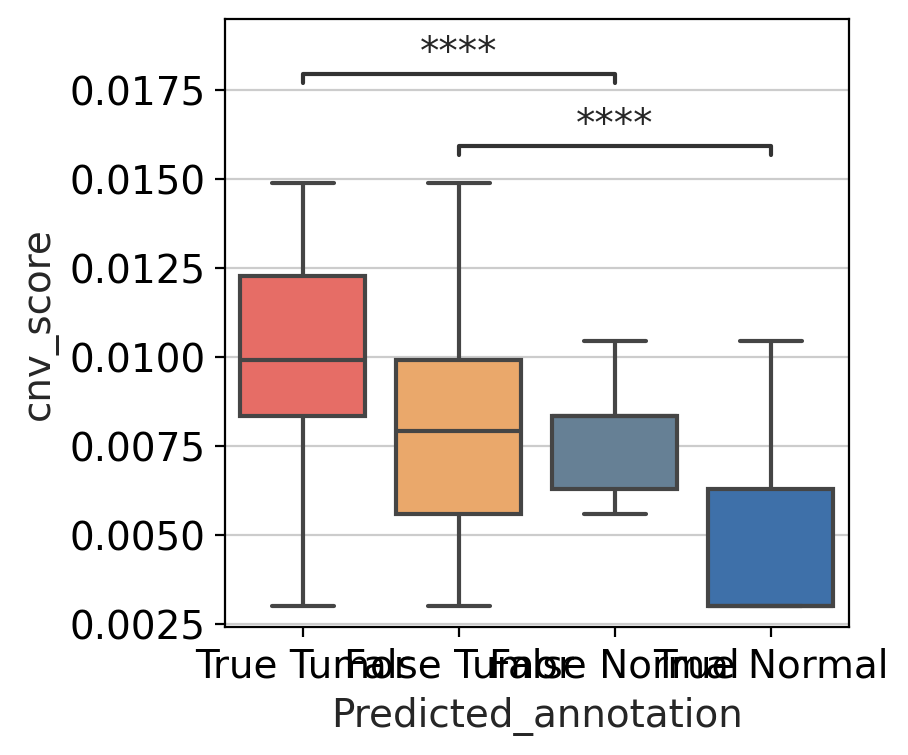

In [20]:
plt.figure(figsize=(4,4))

ax21 = plt.subplot(111)
ax = sns.boxplot(data=adata.obs, x="Predicted_annotation", y='cnv_score', ax=ax21, fliersize=0, palette=['#fc5a50','#ffa756','#5e819d','#2c6fbb'], 
                 order=['True Tumor','False Tumor','False Normal','True Normal'])
annot = Annotator(ax, pairs, data=adata.obs, x="Predicted_annotation", y='cnv_score', order=['True Tumor','False Tumor','False Normal','True Normal'], hide_non_significant=True)
annot.configure(test='t-test_ind', text_format='star', verbose=0)
annot.apply_test()
_ = annot.annotate()
plt.savefig(f'./plot/cnv_score_{prefix}_four_categories.boxplot.pdf', bbox_inches='tight')

In [21]:
col1 = 'Predicted_annotation'
col2 = 'site'
count_df = adata.obs.groupby([col1, col2]).size().to_frame('size').reset_index().pivot(index=col1, columns=col2, values='size')

/tmp/ipykernel_93941/3029049005.py:3: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  count_df = adata.obs.groupby([col1, col2]).size().to_frame('size').reset_index().pivot(index=col1, columns=col2, values='size')


In [22]:
prop_df = count_df.divide(count_df.sum(axis=1), axis=0)

In [23]:
prop_df = prop_df.loc[['True Tumor','False Tumor','False Normal','True Normal']]

INFO:fontTools.subset:maxp pruned
INFO:fontTools.subset:cmap pruned
INFO:fontTools.subset:kern dropped
INFO:fontTools.subset:post pruned
INFO:fontTools.subset:FFTM dropped
INFO:fontTools.subset:GPOS pruned
INFO:fontTools.subset:GSUB pruned
INFO:fontTools.subset:name pruned
INFO:fontTools.subset:glyf pruned
INFO:fontTools.subset:Added gid0 to subset
INFO:fontTools.subset:Added first four glyphs to subset
INFO:fontTools.subset:Closing glyph list over 'GSUB': 35 glyphs before
INFO:fontTools.subset:Glyph names: ['.notdef', '.null', 'F', 'L', 'N', 'P', 'T', 'V', 'a', 'c', 'd', 'e', 'four', 'h', 'i', 'l', 'm', 'n', 'nine', 'nonmarkingreturn', 'o', 'one', 'p', 'period', 'r', 's', 'seven', 'six', 'space', 't', 'two', 'u', 'underscore', 'y', 'zero']
INFO:fontTools.subset:Glyph IDs:   [0, 1, 2, 3, 17, 19, 20, 21, 23, 25, 26, 28, 41, 47, 49, 51, 55, 57, 66, 68, 70, 71, 72, 75, 76, 79, 80, 81, 82, 83, 85, 86, 87, 88, 92]
INFO:fontTools.subset:Closed glyph list over 'GSUB': 35 glyphs after
INFO:fon

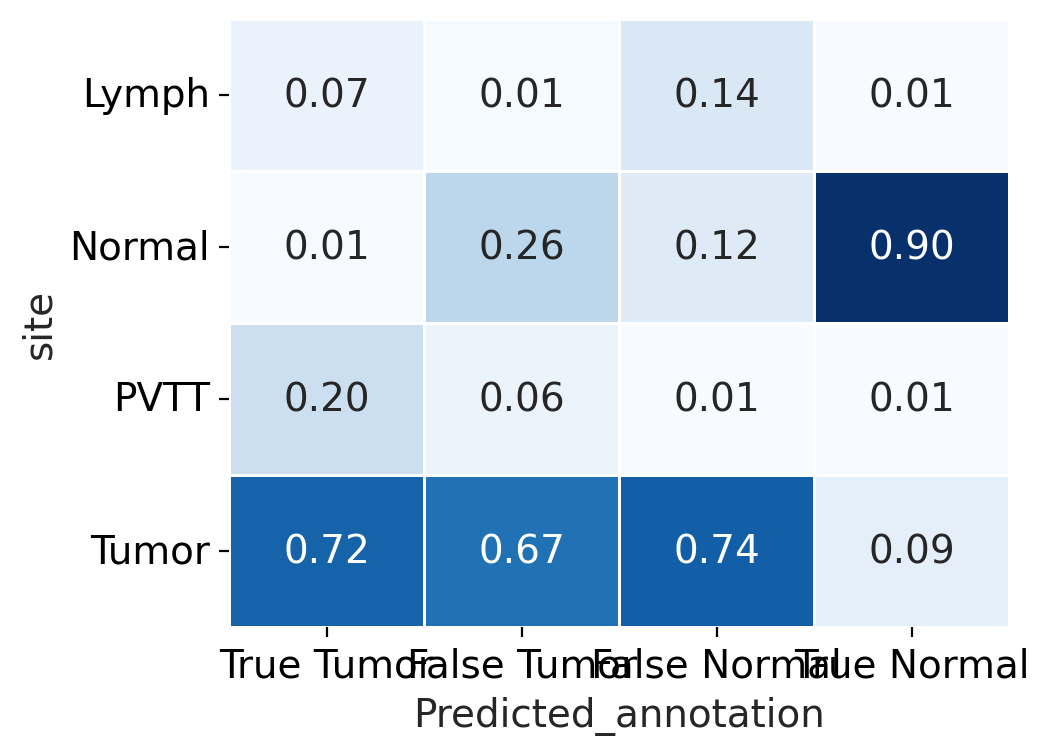

In [24]:
plt.figure(figsize=(5,4))
ax21 = plt.subplot(111)
sns.heatmap(prop_df.T, annot=True, fmt='.2f', cmap='Blues', yticklabels=True, cbar=False, ax=ax21, 
            linewidth=1)
_ = plt.xticks(rotation=0)
_ = plt.yticks(rotation=0)
plt.savefig(f'./plot/sample_proportion_{prefix}_four_categories.heatmap.pdf', bbox_inches='tight')

In [25]:
for stage in adata.obs['stage'].unique():
    print(stage)
    print(adata.obs[adata.obs['stage']==stage]['Raw_annotation'].value_counts())

I
Raw_annotation
Tumor     5619
Normal     910
Name: count, dtype: int64
IIIB
Raw_annotation
Tumor     5163
Normal     188
Name: count, dtype: int64
IIIA
Raw_annotation
Tumor     1339
Normal     427
Name: count, dtype: int64
II
Raw_annotation
Tumor     2660
Normal     120
Name: count, dtype: int64
IV
Raw_annotation
Tumor     4128
Normal     228
Name: count, dtype: int64


In [26]:
adata.obs['stage'].unique()

['I', 'IIIB', 'IIIA', 'II', 'IV']
Categories (5, object): ['I', 'II', 'IIIA', 'IIIB', 'IV']

In [27]:
stage_ls = ['I or II', 'III or IV']
metric_ls = []
for stage in stage_ls:
    if stage == 'I or II':
        stage_cells = adata.obs[adata.obs['stage'].isin(['I','II'])].index.tolist()
    elif stage == 'III or IV':
        stage_cells = adata.obs[adata.obs['stage'].isin(['IIIB','IIIA','IV'])].index.tolist()
        
    result_df2 = pd.concat([adata.obs.loc[stage_cells,'Raw_annotation'].to_frame(), adata.obs.loc[stage_cells,'Prediction'].to_frame()], axis=1)

    metric_df = pd.DataFrame(index=['Accuracy','Balanced_accuracy','Sensitivity','Specificity','PPV','NPV'], columns=[stage])
    tumor_result_df = result_df2[result_df2['Raw_annotation']=='Tumor']
    normal_result_df = result_df2[result_df2['Raw_annotation']=='Normal']
    method = 'Prediction'
    method_tumor_result_df = result_df2[result_df2['Prediction']=='Tumor']
    method_normal_result_df = result_df2[result_df2[method]=='Normal']
    metric_df.loc['Accuracy',stage] = result_df2[result_df2['Raw_annotation']==result_df2[method]].shape[0] / result_df2.shape[0]
    metric_df.loc['Sensitivity',stage] = tumor_result_df[tumor_result_df['Raw_annotation']==tumor_result_df[method]].shape[0] / tumor_result_df.shape[0]
    metric_df.loc['Specificity',stage] = normal_result_df[normal_result_df['Raw_annotation']==normal_result_df[method]].shape[0] / normal_result_df.shape[0]
    metric_df.loc['Balanced_accuracy',stage] = (metric_df.loc['Sensitivity',stage]+metric_df.loc['Specificity',stage]) / 2
    if method_tumor_result_df.shape[0]==0:
        metric_df.loc['PPV',stage] = np.nan
    else:
        metric_df.loc['PPV',stage] = method_tumor_result_df[method_tumor_result_df['Raw_annotation']==method_tumor_result_df[method]].shape[0] / method_tumor_result_df.shape[0]
    if method_normal_result_df.shape[0]==0:
        metric_df.loc['NPV',stage] = np.nan
    else:
        metric_df.loc['NPV',stage] = method_normal_result_df[method_normal_result_df['Raw_annotation']==method_normal_result_df[method]].shape[0] / method_normal_result_df.shape[0]
    metric_df = metric_df.applymap(float)
    
    pred_df = pd.read_csv(f'./file/proba/scMalignantFinder/test_{prefix}', index_col=0).loc[stage_cells]
    pred_df['label'] = adata.obs.loc[stage_cells,'Raw_annotation'].map(label_dict).tolist()
    
    tmp_metric_df = metric_df.T
    tmp_metric_df['AUROC'] = roc_auc_score(pred_df['label'].values, pred_df['Tumor'].values)
    metric_df = tmp_metric_df.T.loc[['AUROC','Accuracy','Balanced_accuracy','Sensitivity','Specificity','PPV','NPV']]
    metric_ls.append(metric_df)
    
combine_metric_df = pd.concat(metric_ls, axis=1)

/tmp/ipykernel_93941/3215711632.py:29: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  metric_df = metric_df.applymap(float)
/tmp/ipykernel_93941/3215711632.py:29: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  metric_df = metric_df.applymap(float)


INFO:fontTools.subset:maxp pruned
INFO:fontTools.subset:cmap pruned
INFO:fontTools.subset:kern dropped
INFO:fontTools.subset:post pruned
INFO:fontTools.subset:FFTM dropped
INFO:fontTools.subset:GPOS pruned
INFO:fontTools.subset:GSUB pruned
INFO:fontTools.subset:name pruned
INFO:fontTools.subset:glyf pruned
INFO:fontTools.subset:Added gid0 to subset
INFO:fontTools.subset:Added first four glyphs to subset
INFO:fontTools.subset:Closing glyph list over 'GSUB': 43 glyphs before
INFO:fontTools.subset:Glyph names: ['.notdef', '.null', 'A', 'B', 'C', 'I', 'N', 'O', 'P', 'R', 'S', 'U', 'V', 'a', 'c', 'd', 'e', 'eight', 'f', 'five', 'four', 'i', 'l', 'n', 'nine', 'nonmarkingreturn', 'o', 'one', 'p', 'period', 'r', 's', 'seven', 'six', 'space', 't', 'three', 'two', 'u', 'underscore', 'v', 'y', 'zero']
INFO:fontTools.subset:Glyph IDs:   [0, 1, 2, 3, 17, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 36, 37, 38, 44, 49, 50, 51, 53, 54, 56, 57, 66, 68, 70, 71, 72, 73, 76, 79, 81, 82, 83, 85, 86, 87, 88, 89

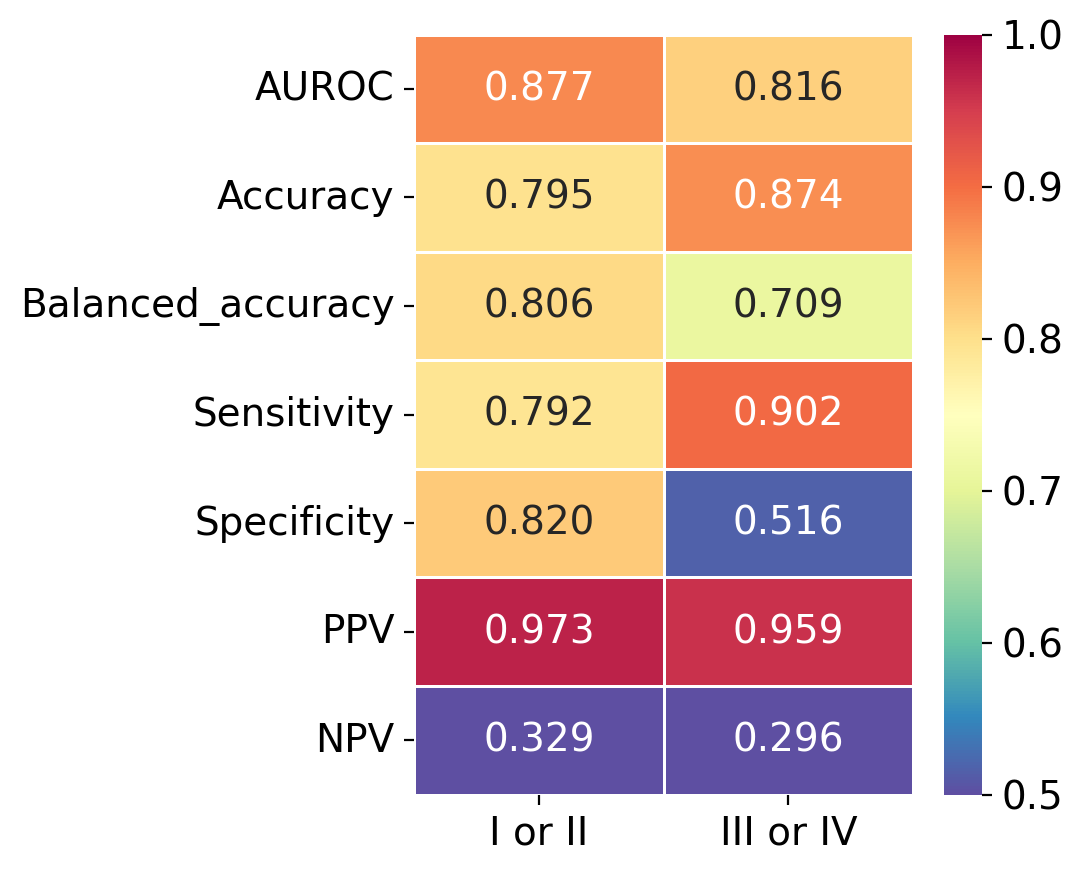

In [28]:
plt.figure(figsize=(4,5))
ax21 = plt.subplot(111)
sns.heatmap(combine_metric_df, annot=True, fmt='.3f', cmap='Spectral_r', yticklabels=True, cbar=True, ax=ax21, linewidth=1, vmin=0.5, vmax=1)
_ = plt.xticks(rotation=0)
plt.savefig(f'./plot/metric_{prefix}_stage.heatmap.pdf', bbox_inches='tight')

In [29]:
metric_ls = []
for stage in ['I', 'II', 'IIIA', 'IIIB', 'IV']:
    stage_cells = adata.obs[adata.obs['stage']==stage].index.tolist()
        
    result_df2 = pd.concat([adata.obs.loc[stage_cells,'Raw_annotation'].to_frame(), adata.obs.loc[stage_cells,'Prediction'].to_frame()], axis=1)

    metric_df = pd.DataFrame(index=['Accuracy','Balanced_accuracy','Sensitivity','Specificity','PPV','NPV'], columns=[stage])
    tumor_result_df = result_df2[result_df2['Raw_annotation']=='Tumor']
    normal_result_df = result_df2[result_df2['Raw_annotation']=='Normal']
    method = 'Prediction'
    method_tumor_result_df = result_df2[result_df2['Prediction']=='Tumor']
    method_normal_result_df = result_df2[result_df2[method]=='Normal']
    metric_df.loc['Accuracy',stage] = result_df2[result_df2['Raw_annotation']==result_df2[method]].shape[0] / result_df2.shape[0]
    metric_df.loc['Sensitivity',stage] = tumor_result_df[tumor_result_df['Raw_annotation']==tumor_result_df[method]].shape[0] / tumor_result_df.shape[0]
    metric_df.loc['Specificity',stage] = normal_result_df[normal_result_df['Raw_annotation']==normal_result_df[method]].shape[0] / normal_result_df.shape[0]
    metric_df.loc['Balanced_accuracy',stage] = (metric_df.loc['Sensitivity',stage]+metric_df.loc['Specificity',stage]) / 2
    if method_tumor_result_df.shape[0]==0:
        metric_df.loc['PPV',stage] = np.nan
    else:
        metric_df.loc['PPV',stage] = method_tumor_result_df[method_tumor_result_df['Raw_annotation']==method_tumor_result_df[method]].shape[0] / method_tumor_result_df.shape[0]
    if method_normal_result_df.shape[0]==0:
        metric_df.loc['NPV',stage] = np.nan
    else:
        metric_df.loc['NPV',stage] = method_normal_result_df[method_normal_result_df['Raw_annotation']==method_normal_result_df[method]].shape[0] / method_normal_result_df.shape[0]
    metric_df = metric_df.applymap(float)
    
    pred_df = pd.read_csv(f'./file/proba/scMalignantFinder/test_{prefix}', index_col=0).loc[stage_cells]
    pred_df['label'] = adata.obs.loc[stage_cells,'Raw_annotation'].map(label_dict).tolist()
    
    tmp_metric_df = metric_df.T
    tmp_metric_df['AUROC'] = roc_auc_score(pred_df['label'].values, pred_df['Tumor'].values)
    metric_df = tmp_metric_df.T.loc[['AUROC','Accuracy','Balanced_accuracy','Sensitivity','Specificity','PPV','NPV']]
    metric_ls.append(metric_df)
    
combine_metric_df = pd.concat(metric_ls, axis=1)

/tmp/ipykernel_93941/2600726152.py:25: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  metric_df = metric_df.applymap(float)
/tmp/ipykernel_93941/2600726152.py:25: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  metric_df = metric_df.applymap(float)
/tmp/ipykernel_93941/2600726152.py:25: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  metric_df = metric_df.applymap(float)
/tmp/ipykernel_93941/2600726152.py:25: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  metric_df = metric_df.applymap(float)
/tmp/ipykernel_93941/2600726152.py:25: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  metric_df = metric_df.applymap(float)


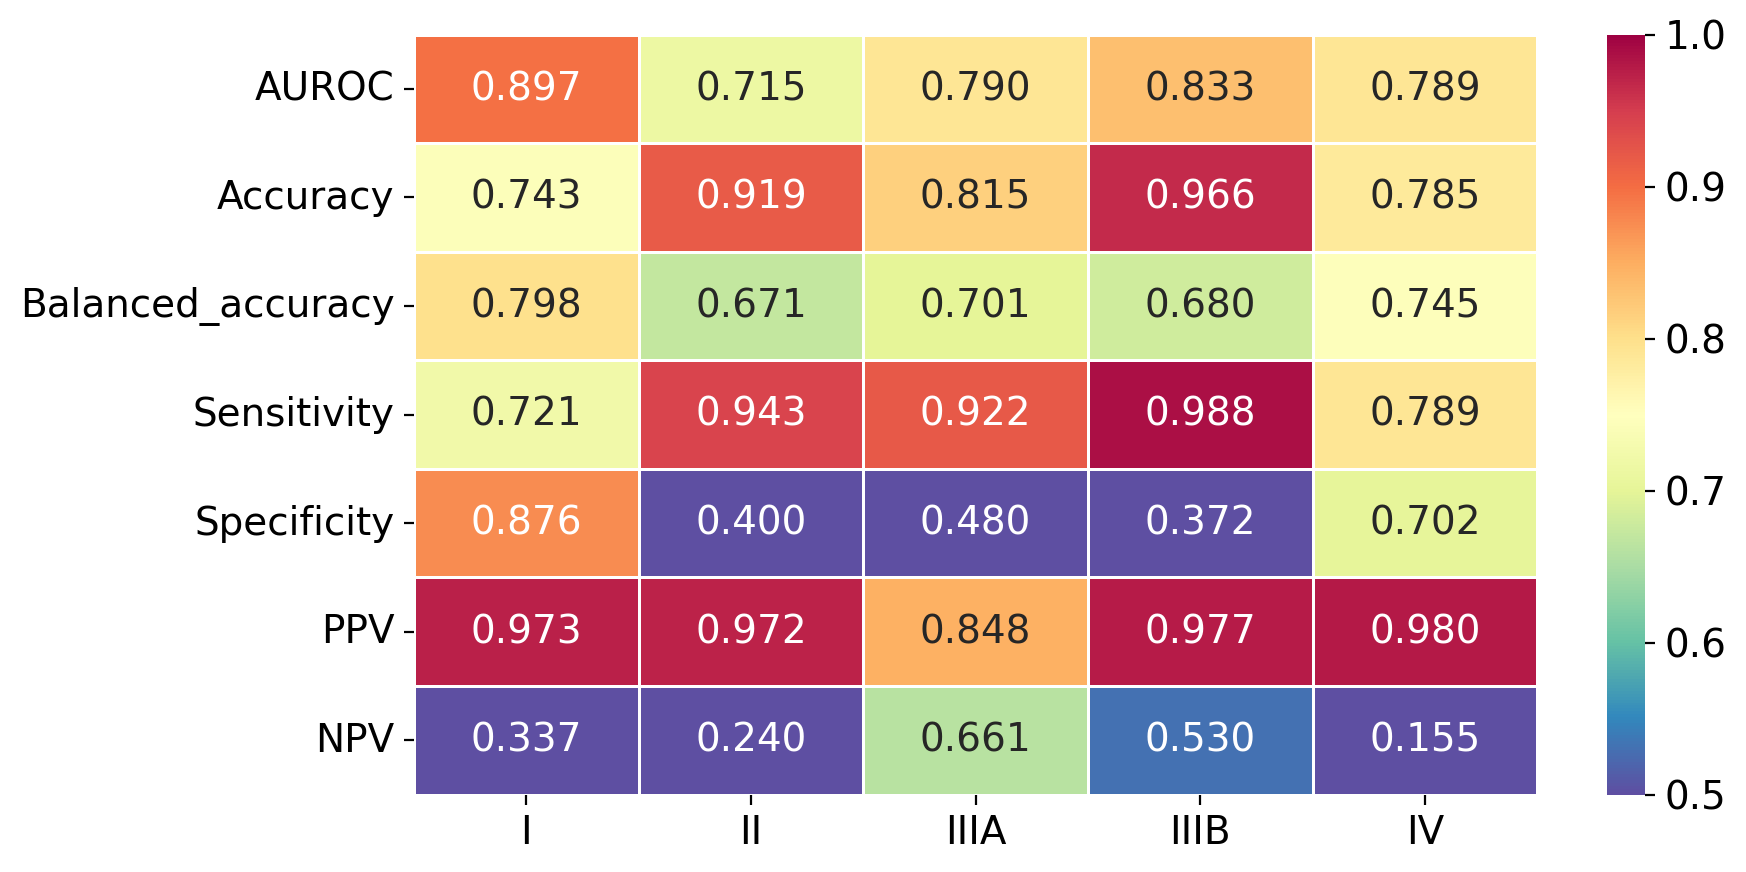

In [30]:
plt.figure(figsize=(9,5))
ax21 = plt.subplot(111)
sns.heatmap(combine_metric_df, annot=True, fmt='.3f', cmap='Spectral_r', yticklabels=True, cbar=True, ax=ax21, linewidth=1, vmin=0.5, vmax=1)
_ = plt.xticks(rotation=0)

In [31]:
pairs = []
for geneset in sel_genesets:
    pairs.append(((geneset,'False Tumor'),(geneset,'True Normal')))
    pairs.append(((geneset,'False Normal'),(geneset,'True Tumor')))

INFO:fontTools.subset:maxp pruned
INFO:fontTools.subset:cmap pruned
INFO:fontTools.subset:kern dropped
INFO:fontTools.subset:post pruned
INFO:fontTools.subset:FFTM dropped
INFO:fontTools.subset:GPOS pruned
INFO:fontTools.subset:GSUB pruned
INFO:fontTools.subset:name pruned
INFO:fontTools.subset:glyf pruned
INFO:fontTools.subset:Added gid0 to subset
INFO:fontTools.subset:Added first four glyphs to subset
INFO:fontTools.subset:Closing glyph list over 'GSUB': 56 glyphs before
INFO:fontTools.subset:Glyph names: ['.notdef', '.null', 'A', 'C', 'D', 'E', 'F', 'G', 'I', 'L', 'M', 'N', 'R', 'S', 'T', 'U', 'a', 'asterisk', 'b', 'c', 'comma', 'd', 'e', 'eight', 'equal', 'five', 'four', 'g', 'h', 'hyphen', 'i', 'l', 'm', 'n', 'nine', 'nonmarkingreturn', 'o', 'one', 'p', 'parenleft', 'parenright', 'period', 'r', 's', 'seven', 'six', 'space', 't', 'three', 'two', 'u', 'underscore', 'v', 'w', 'y', 'zero']
INFO:fontTools.subset:Glyph IDs:   [0, 1, 2, 3, 11, 12, 13, 15, 16, 17, 19, 20, 21, 22, 23, 24, 

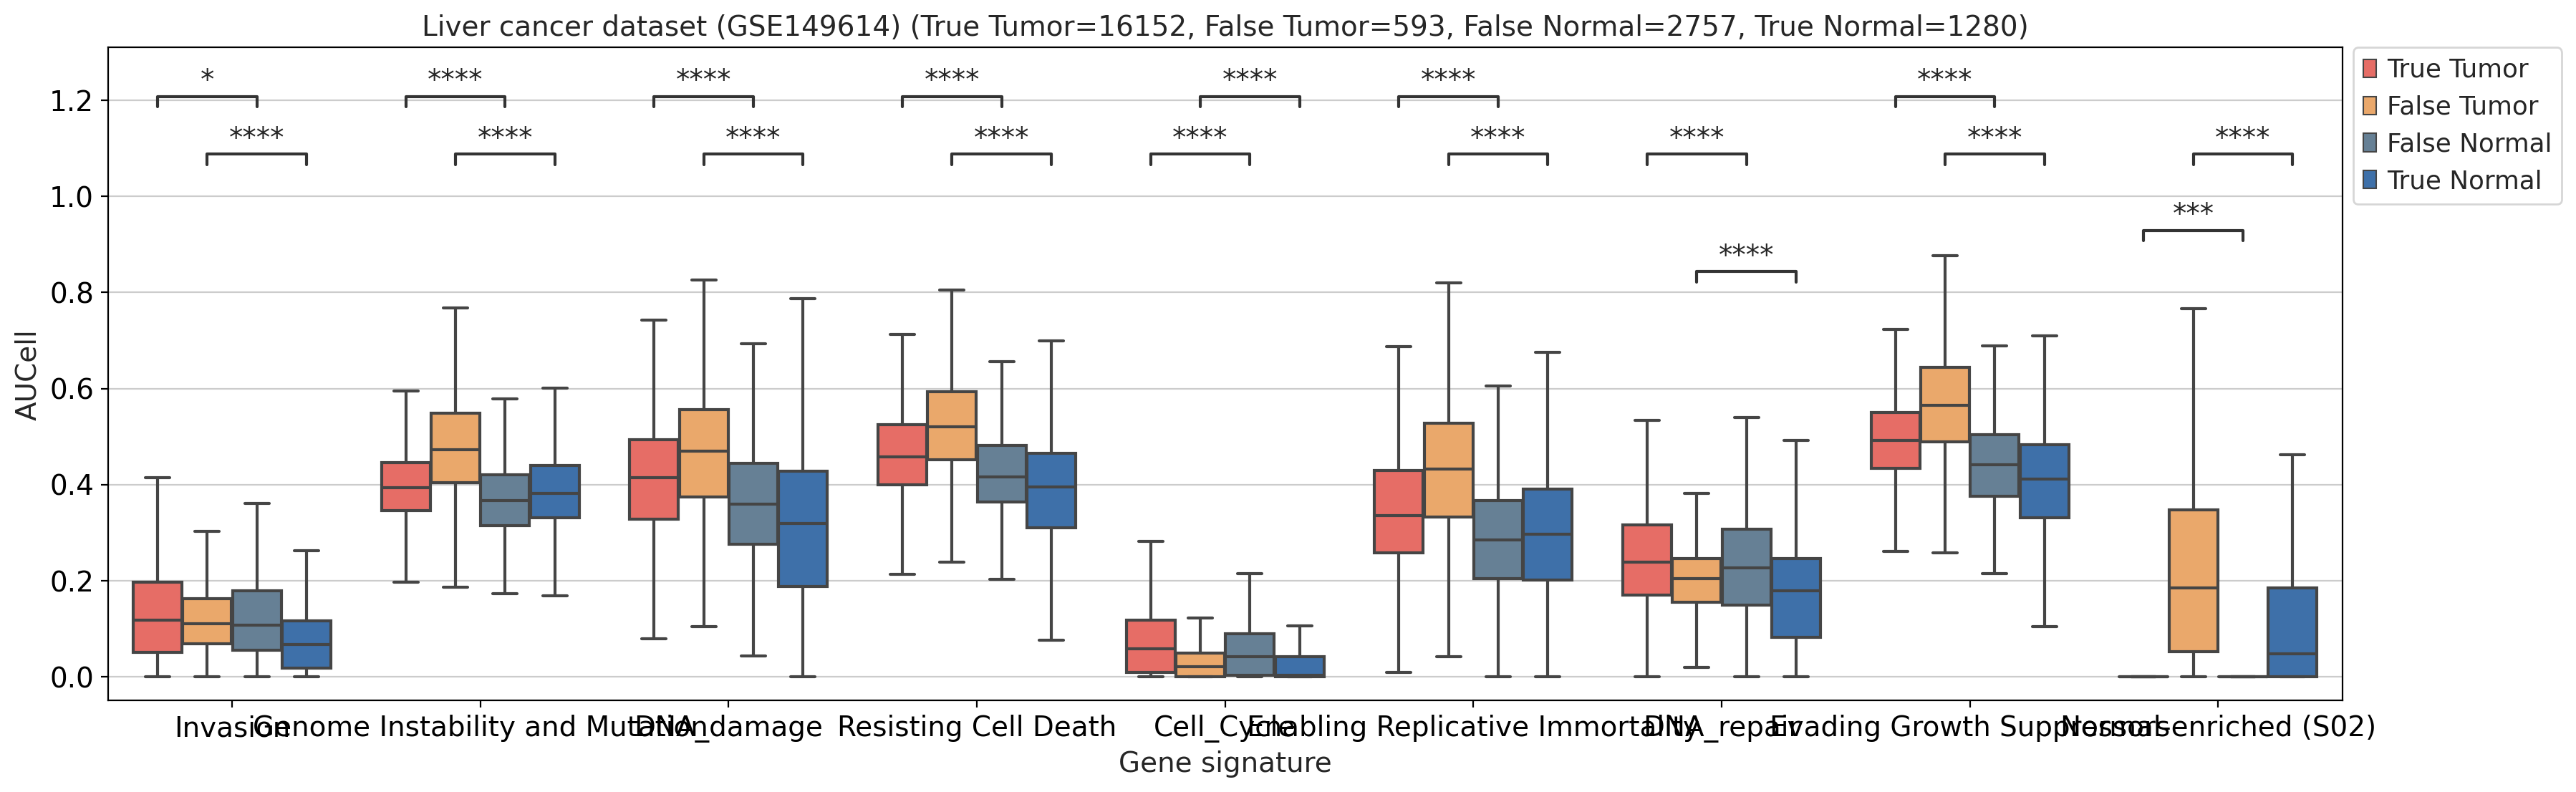

In [32]:
prefix = 'LC2'
plot_df = test_plot_dict[prefix]
plt.figure(figsize=(20,6))
ax = sns.boxplot(x='variable', y='value', hue='Predicted_annotation', data=plot_df, palette=['#fc5a50','#ffa756','#5e819d','#2c6fbb'], 
                 hue_order=['True Tumor','False Tumor','False Normal','True Normal'], fliersize=0)
_ = plt.xlabel('Gene signature')
_ = plt.ylabel('AUCell')
nb_true_tumor = (adata.obs['Predicted_annotation']=='True Tumor').sum()
nb_false_tumor = (adata.obs['Predicted_annotation']=='False Tumor').sum()
nb_true_normal = (adata.obs['Predicted_annotation']=='True Normal').sum()
nb_false_normal = (adata.obs['Predicted_annotation']=='False Normal').sum()
_ = plt.title('{0} (True Tumor={1}, False Tumor={2}, False Normal={3}, True Normal={4})'.format(title, nb_true_tumor, nb_false_tumor, nb_false_normal, nb_true_normal))
annot = Annotator(ax, pairs, x='variable', y='value', hue='Predicted_annotation', data=plot_df, hue_order=['True Tumor','False Tumor','False Normal','True Normal'], hide_non_significant=True)
annot.configure(test='t-test_ind', text_format='star', verbose=0)
annot.apply_test()
annot.annotate()
plt.legend(bbox_to_anchor=(1.005, 1), loc='upper left', borderaxespad=0)
_ = plt.xlim([-0.5,8.5])
plt.savefig(f'./plot/cancer_hallmarks_{prefix}_four_categories.boxplot.pdf', bbox_inches='tight')

INFO:fontTools.subset:maxp pruned
INFO:fontTools.subset:cmap pruned
INFO:fontTools.subset:kern dropped
INFO:fontTools.subset:post pruned
INFO:fontTools.subset:FFTM dropped
INFO:fontTools.subset:GPOS pruned
INFO:fontTools.subset:GSUB pruned
INFO:fontTools.subset:name pruned
INFO:fontTools.subset:glyf pruned
INFO:fontTools.subset:Added gid0 to subset
INFO:fontTools.subset:Added first four glyphs to subset
INFO:fontTools.subset:Closing glyph list over 'GSUB': 56 glyphs before
INFO:fontTools.subset:Glyph names: ['.notdef', '.null', 'A', 'C', 'D', 'E', 'F', 'G', 'I', 'L', 'M', 'N', 'R', 'S', 'T', 'U', 'a', 'asterisk', 'b', 'c', 'comma', 'd', 'e', 'eight', 'equal', 'five', 'four', 'g', 'h', 'hyphen', 'i', 'l', 'm', 'n', 'nine', 'nonmarkingreturn', 'o', 'one', 'p', 'parenleft', 'parenright', 'period', 'r', 's', 'seven', 'six', 'space', 't', 'three', 'two', 'u', 'underscore', 'v', 'w', 'y', 'zero']
INFO:fontTools.subset:Glyph IDs:   [0, 1, 2, 3, 11, 12, 13, 15, 16, 17, 19, 20, 21, 22, 23, 24, 

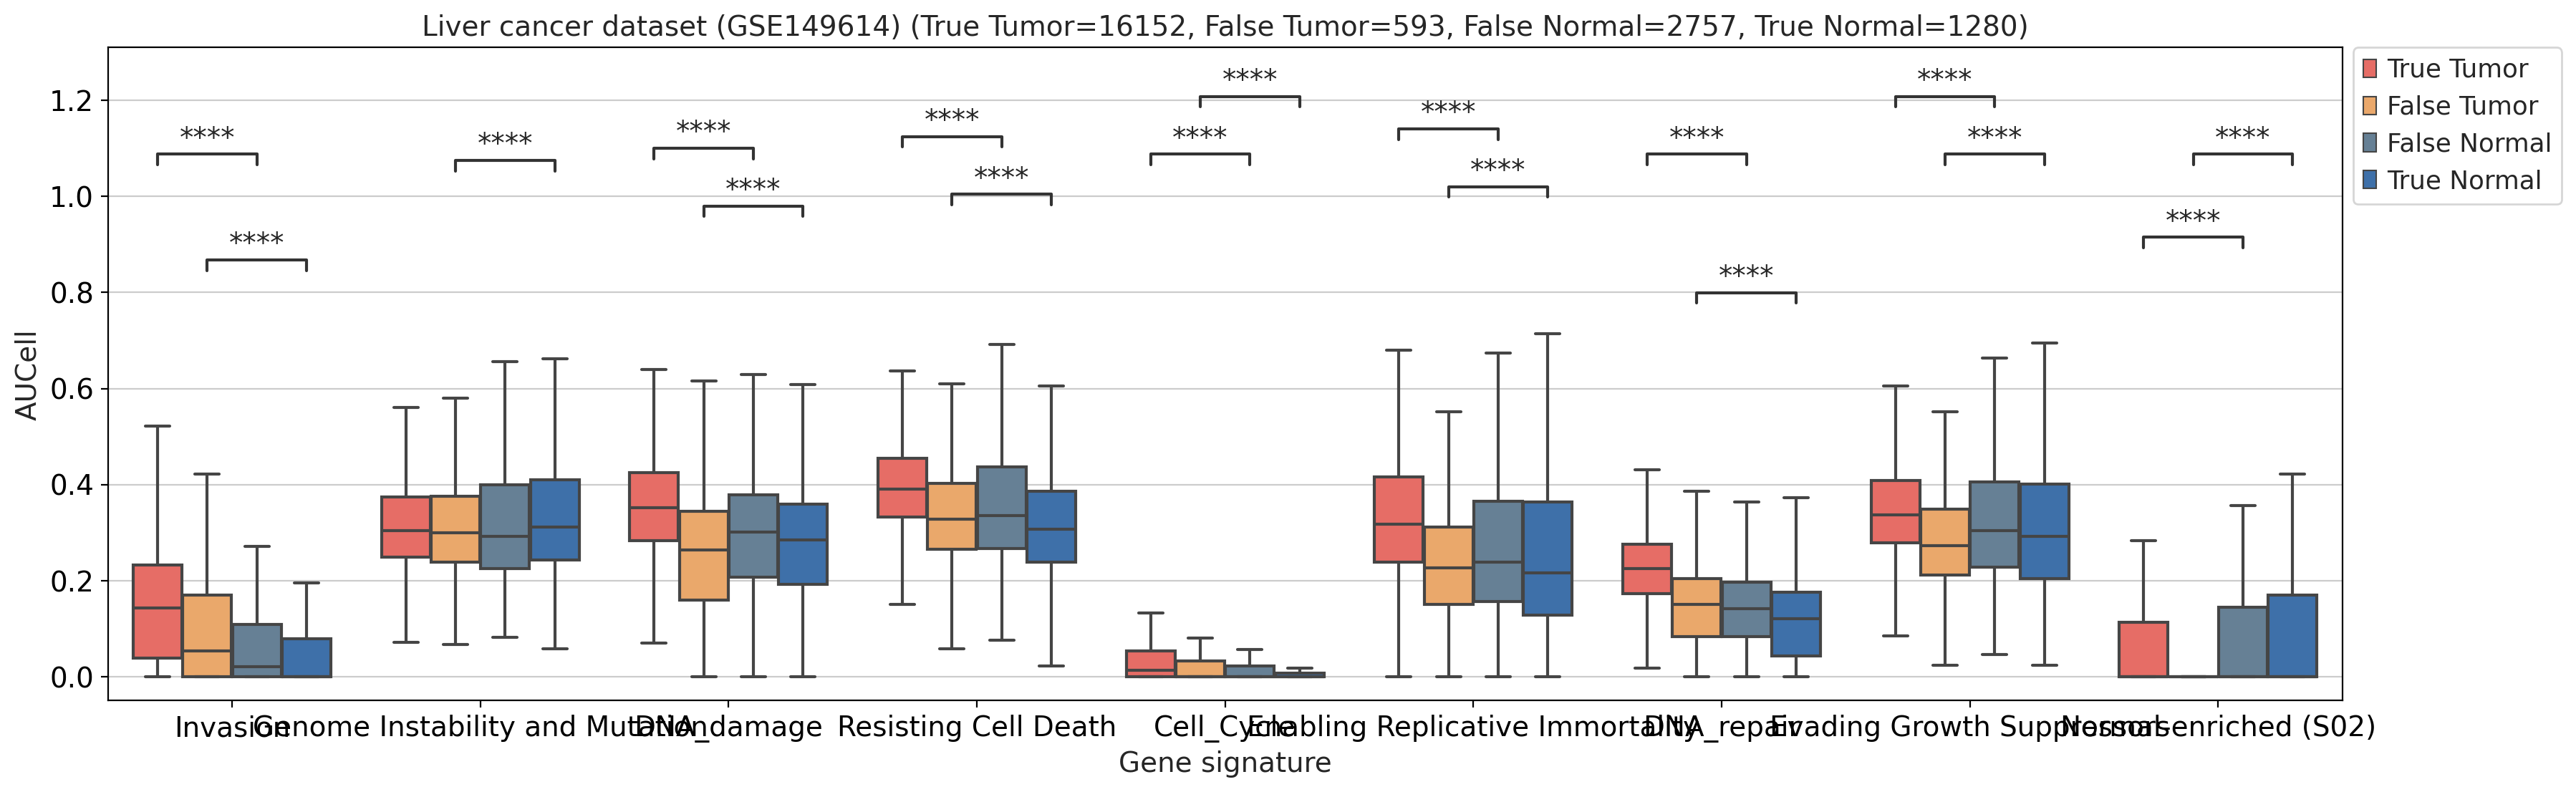

In [33]:
prefix = 'LC3'
plot_df = test_plot_dict[prefix]
plt.figure(figsize=(20,6))
ax = sns.boxplot(x='variable', y='value', hue='Predicted_annotation', data=plot_df, palette=['#fc5a50','#ffa756','#5e819d','#2c6fbb'], 
                 hue_order=['True Tumor','False Tumor','False Normal','True Normal'], fliersize=0)
_ = plt.xlabel('Gene signature')
_ = plt.ylabel('AUCell')
nb_true_tumor = (adata.obs['Predicted_annotation']=='True Tumor').sum()
nb_false_tumor = (adata.obs['Predicted_annotation']=='False Tumor').sum()
nb_true_normal = (adata.obs['Predicted_annotation']=='True Normal').sum()
nb_false_normal = (adata.obs['Predicted_annotation']=='False Normal').sum()
_ = plt.title('{0} (True Tumor={1}, False Tumor={2}, False Normal={3}, True Normal={4})'.format(title, nb_true_tumor, nb_false_tumor, nb_false_normal, nb_true_normal))
annot = Annotator(ax, pairs, x='variable', y='value', hue='Predicted_annotation', data=plot_df, hue_order=['True Tumor','False Tumor','False Normal','True Normal'], hide_non_significant=True)
annot.configure(test='t-test_ind', text_format='star', verbose=0)
annot.apply_test()
annot.annotate()
plt.legend(bbox_to_anchor=(1.005, 1), loc='upper left', borderaxespad=0)
_ = plt.xlim([-0.5,8.5])
plt.savefig(f'./plot/cancer_hallmarks_{prefix}_four_categories.boxplot.pdf', bbox_inches='tight')

INFO:fontTools.subset:maxp pruned
INFO:fontTools.subset:cmap pruned
INFO:fontTools.subset:kern dropped
INFO:fontTools.subset:post pruned
INFO:fontTools.subset:FFTM dropped
INFO:fontTools.subset:GPOS pruned
INFO:fontTools.subset:GSUB pruned
INFO:fontTools.subset:name pruned
INFO:fontTools.subset:glyf pruned
INFO:fontTools.subset:Added gid0 to subset
INFO:fontTools.subset:Added first four glyphs to subset
INFO:fontTools.subset:Closing glyph list over 'GSUB': 56 glyphs before
INFO:fontTools.subset:Glyph names: ['.notdef', '.null', 'A', 'C', 'D', 'E', 'F', 'G', 'I', 'L', 'M', 'N', 'R', 'S', 'T', 'U', 'a', 'asterisk', 'b', 'c', 'comma', 'd', 'e', 'eight', 'equal', 'five', 'four', 'g', 'h', 'hyphen', 'i', 'l', 'm', 'n', 'nine', 'nonmarkingreturn', 'o', 'one', 'p', 'parenleft', 'parenright', 'period', 'r', 's', 'seven', 'six', 'space', 't', 'three', 'two', 'u', 'underscore', 'v', 'w', 'y', 'zero']
INFO:fontTools.subset:Glyph IDs:   [0, 1, 2, 3, 11, 12, 13, 15, 16, 17, 19, 20, 21, 22, 23, 24, 

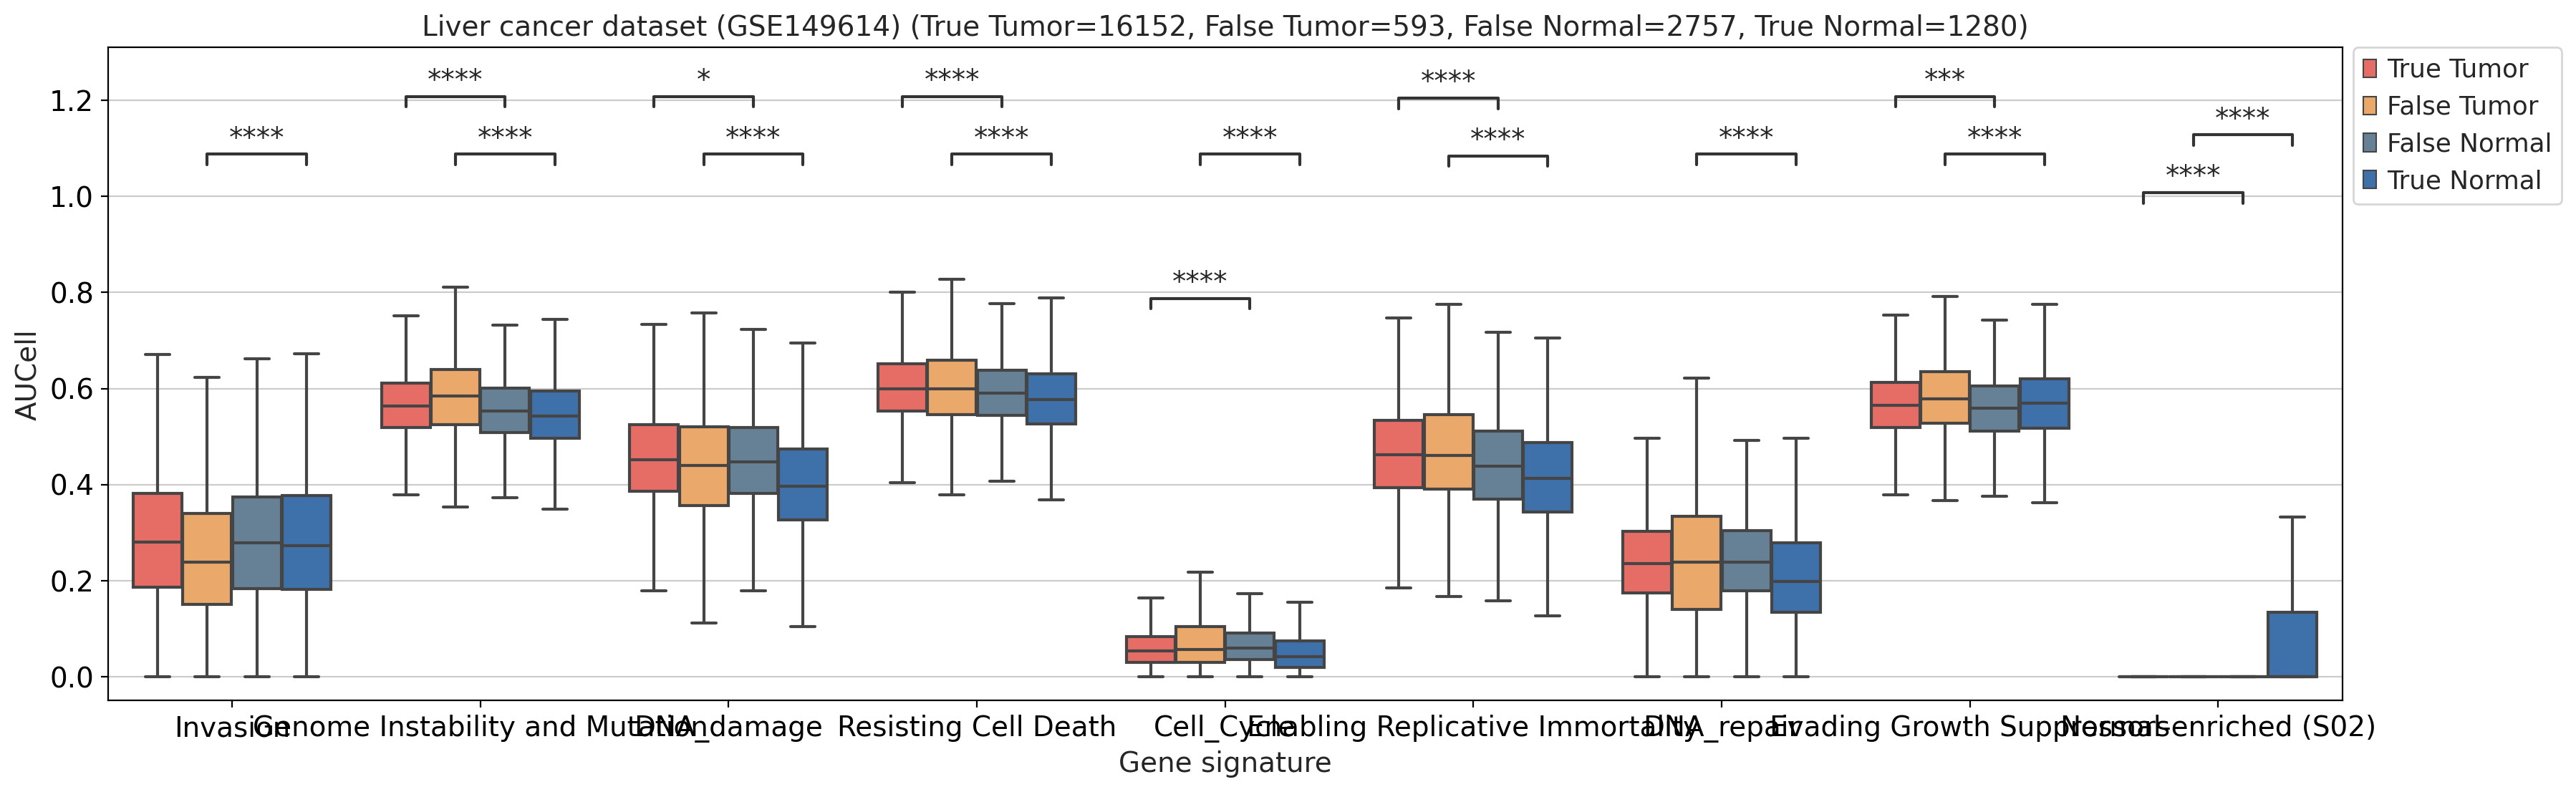

In [34]:
prefix = 'CRC1'
plot_df = test_plot_dict[prefix]
plt.figure(figsize=(20,6))
ax = sns.boxplot(x='variable', y='value', hue='Predicted_annotation', data=plot_df, palette=['#fc5a50','#ffa756','#5e819d','#2c6fbb'], 
                 hue_order=['True Tumor','False Tumor','False Normal','True Normal'], fliersize=0)
_ = plt.xlabel('Gene signature')
_ = plt.ylabel('AUCell')
nb_true_tumor = (adata.obs['Predicted_annotation']=='True Tumor').sum()
nb_false_tumor = (adata.obs['Predicted_annotation']=='False Tumor').sum()
nb_true_normal = (adata.obs['Predicted_annotation']=='True Normal').sum()
nb_false_normal = (adata.obs['Predicted_annotation']=='False Normal').sum()
_ = plt.title('{0} (True Tumor={1}, False Tumor={2}, False Normal={3}, True Normal={4})'.format(title, nb_true_tumor, nb_false_tumor, nb_false_normal, nb_true_normal))
annot = Annotator(ax, pairs, x='variable', y='value', hue='Predicted_annotation', data=plot_df, hue_order=['True Tumor','False Tumor','False Normal','True Normal'], hide_non_significant=True)
annot.configure(test='t-test_ind', text_format='star', verbose=0)
annot.apply_test()
annot.annotate()
plt.legend(bbox_to_anchor=(1.005, 1), loc='upper left', borderaxespad=0)
_ = plt.xlim([-0.5,8.5])
plt.savefig(f'./plot/cancer_hallmarks_{prefix}_four_categories.boxplot.pdf', bbox_inches='tight')

INFO:fontTools.subset:maxp pruned
INFO:fontTools.subset:cmap pruned
INFO:fontTools.subset:kern dropped
INFO:fontTools.subset:post pruned
INFO:fontTools.subset:FFTM dropped
INFO:fontTools.subset:GPOS pruned
INFO:fontTools.subset:GSUB pruned
INFO:fontTools.subset:name pruned
INFO:fontTools.subset:glyf pruned
INFO:fontTools.subset:Added gid0 to subset
INFO:fontTools.subset:Added first four glyphs to subset
INFO:fontTools.subset:Closing glyph list over 'GSUB': 56 glyphs before
INFO:fontTools.subset:Glyph names: ['.notdef', '.null', 'A', 'C', 'D', 'E', 'F', 'G', 'I', 'L', 'M', 'N', 'R', 'S', 'T', 'U', 'a', 'asterisk', 'b', 'c', 'comma', 'd', 'e', 'eight', 'equal', 'five', 'four', 'g', 'h', 'hyphen', 'i', 'l', 'm', 'n', 'nine', 'nonmarkingreturn', 'o', 'one', 'p', 'parenleft', 'parenright', 'period', 'r', 's', 'seven', 'six', 'space', 't', 'three', 'two', 'u', 'underscore', 'v', 'w', 'y', 'zero']
INFO:fontTools.subset:Glyph IDs:   [0, 1, 2, 3, 11, 12, 13, 15, 16, 17, 19, 20, 21, 22, 23, 24, 

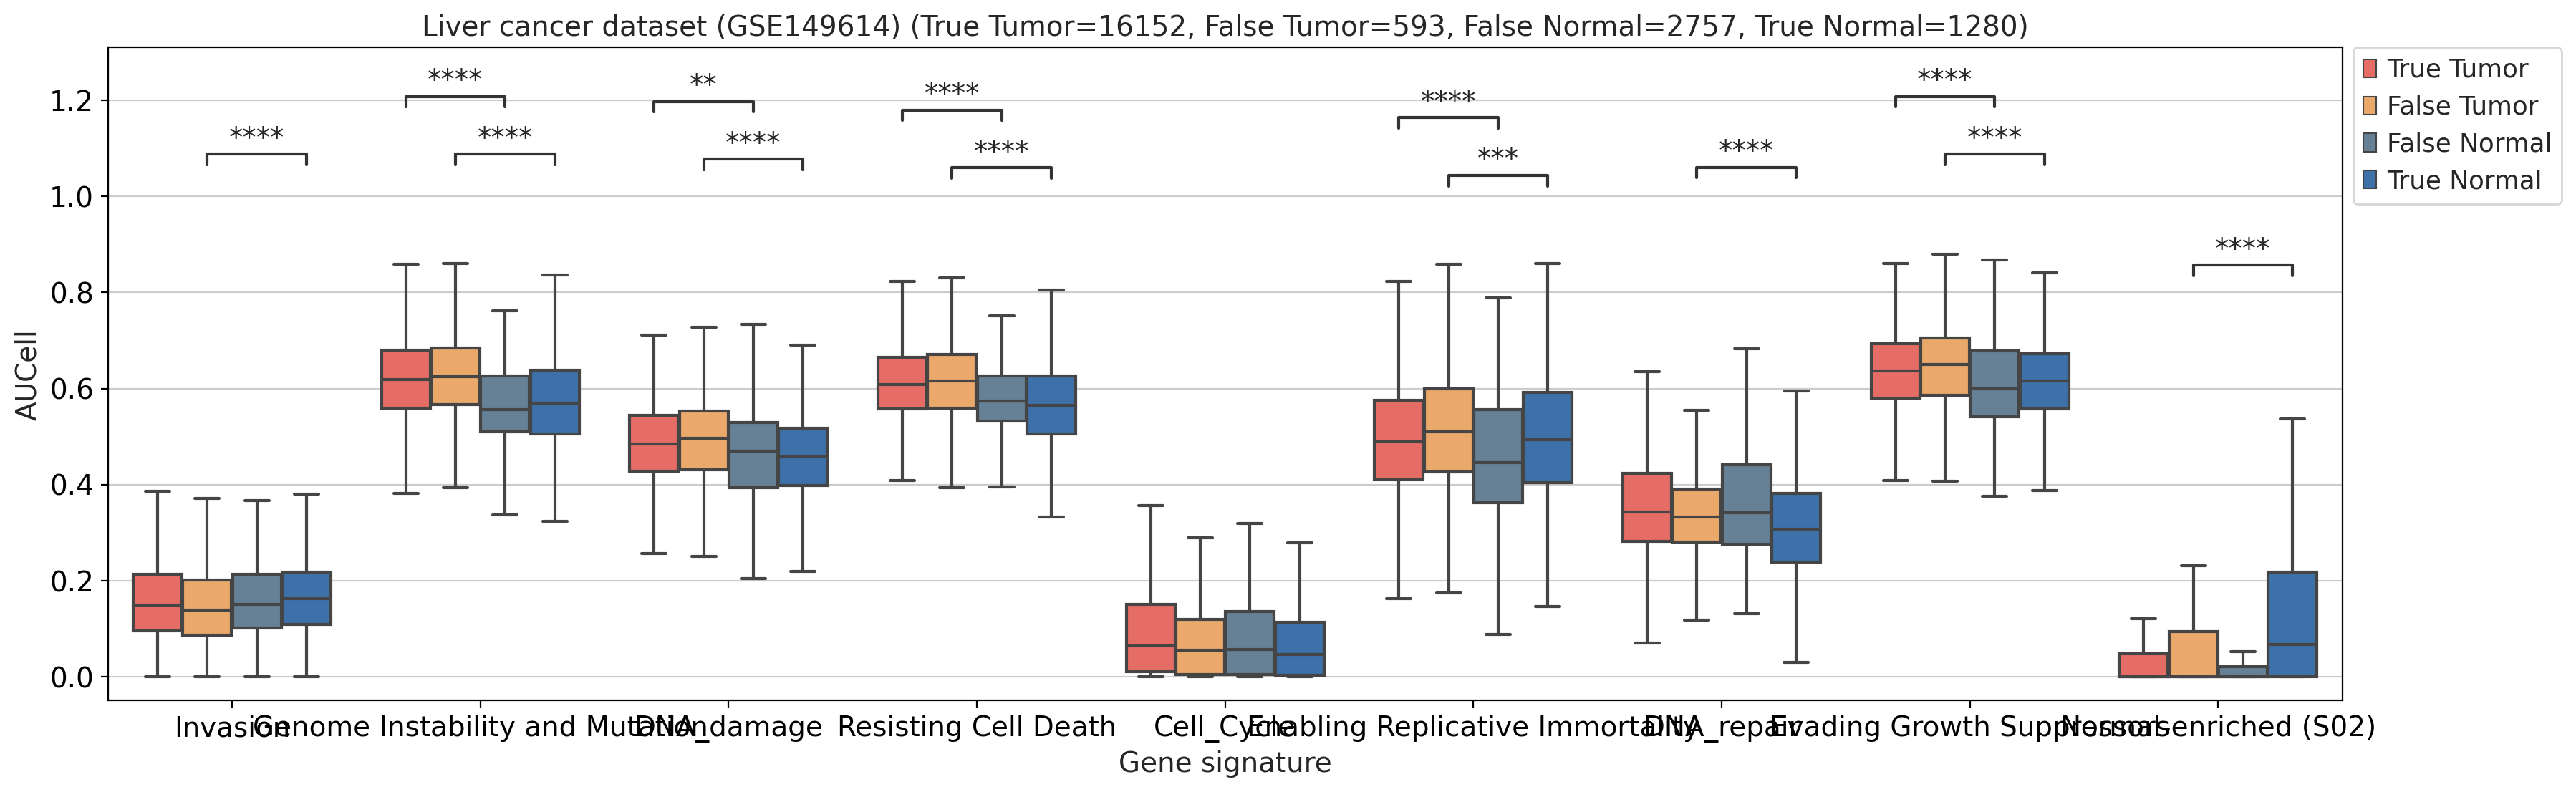

In [35]:
prefix = 'CRC2'
plot_df = test_plot_dict[prefix]
plt.figure(figsize=(20,6))
ax = sns.boxplot(x='variable', y='value', hue='Predicted_annotation', data=plot_df, palette=['#fc5a50','#ffa756','#5e819d','#2c6fbb'], 
                 hue_order=['True Tumor','False Tumor','False Normal','True Normal'], fliersize=0)
_ = plt.xlabel('Gene signature')
_ = plt.ylabel('AUCell')
nb_true_tumor = (adata.obs['Predicted_annotation']=='True Tumor').sum()
nb_false_tumor = (adata.obs['Predicted_annotation']=='False Tumor').sum()
nb_true_normal = (adata.obs['Predicted_annotation']=='True Normal').sum()
nb_false_normal = (adata.obs['Predicted_annotation']=='False Normal').sum()
_ = plt.title('{0} (True Tumor={1}, False Tumor={2}, False Normal={3}, True Normal={4})'.format(title, nb_true_tumor, nb_false_tumor, nb_false_normal, nb_true_normal))
annot = Annotator(ax, pairs, x='variable', y='value', hue='Predicted_annotation', data=plot_df, hue_order=['True Tumor','False Tumor','False Normal','True Normal'], hide_non_significant=True)
annot.configure(test='t-test_ind', text_format='star', verbose=0)
annot.apply_test()
annot.annotate()
plt.legend(bbox_to_anchor=(1.005, 1), loc='upper left', borderaxespad=0)
_ = plt.xlim([-0.5,8.5])
plt.savefig(f'./plot/cancer_hallmarks_{prefix}_four_categories.boxplot.pdf', bbox_inches='tight')

In [36]:
prefix = 'LC2'
adata = test_adata_dict[prefix]
sc.pp.normalize_total(adata, target_sum=1e4)
sc.pp.log1p(adata)

In [37]:
overlap_genes = list(set(adata.var_names) & set(ref_df['gene_name']))
print(len(overlap_genes))

spec_gene_dict = {
    'GOLGA8M':'1957781','MATR3':'801455','ARMCX5-GPRASP2':'2699327','LINC01238':'353646','TMSB15B':'2700269','HSPA14':'1341394',
    'LINC01505':'1265639','CYB561D2':'493710','GGT1':'2621672','TBCE':'129239'
}

unique_ref_df = ref_df[ref_df['gene_name'].isin(ref_df['gene_name'].value_counts()[ref_df['gene_name'].value_counts()==1].index)]
double_ref_df = ref_df[ref_df['gene_name'].isin(ref_df['gene_name'].value_counts()[ref_df['gene_name'].value_counts()==2].index)]
unique_double_ref_df = double_ref_df.loc[[int(x) for x in list(spec_gene_dict.values())]]

concat_ref_df = pd.concat([unique_ref_df,unique_double_ref_df])
concat_ref_df.index = concat_ref_df['gene_name'].tolist()

concat_ref_df = concat_ref_df.loc[overlap_genes]

adata = adata[:,overlap_genes].copy()

adata.var['chromosome'] = concat_ref_df['Chromosome'].tolist()
adata.var['end'] = concat_ref_df['Start'].tolist()
adata.var['start'] = concat_ref_df['End'].tolist()

23725


In [38]:
cnv.tl.infercnv(
        adata,
        reference_key='Raw_annotation',
        reference_cat=['Normal'],
        window_size=250,
        exclude_chromosomes=['chrX','chrY'],
        chunksize=1000,
        n_jobs=20,
        inplace=True
)

cnv.tl.pca(adata)
cnv.pp.neighbors(adata)

  0%|          | 0/170 [00:00<?, ?it/s]

/mnt/home/qnyu/miniconda3/envs/scverse/lib/python3.10/site-packages/anndata/_core/anndata.py:117: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)
... storing 'Predicted_annotation' as categorical


         Falling back to preprocessing with `sc.pp.pca` and default params.
categories: False Normal, False Tumor, True Normal, etc.
var_group_labels: chr1, chr2, chr3, etc.


/mnt/home/qnyu/miniconda3/envs/scverse/lib/python3.10/site-packages/scanpy/tools/_dendrogram.py:133: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  mean_df = rep_df.groupby(level=0).mean()
INFO:fontTools.subset:maxp pruned
INFO:fontTools.subset:cmap pruned
INFO:fontTools.subset:kern dropped
INFO:fontTools.subset:post pruned
INFO:fontTools.subset:FFTM dropped
INFO:fontTools.subset:GPOS pruned
INFO:fontTools.subset:GSUB pruned
INFO:fontTools.subset:name pruned
INFO:fontTools.subset:glyf pruned
INFO:fontTools.subset:Added gid0 to subset
INFO:fontTools.subset:Added first four glyphs to subset
INFO:fontTools.subset:Closing glyph list over 'GSUB': 35 glyphs before
INFO:fontTools.subset:Glyph names: ['.notdef', '.null', 'F', 'N', 'P', 'T', 'a', 'c', 'd', 'e', 'eight', 'five', 'four', 'h', 'i', 'l', 'm', '

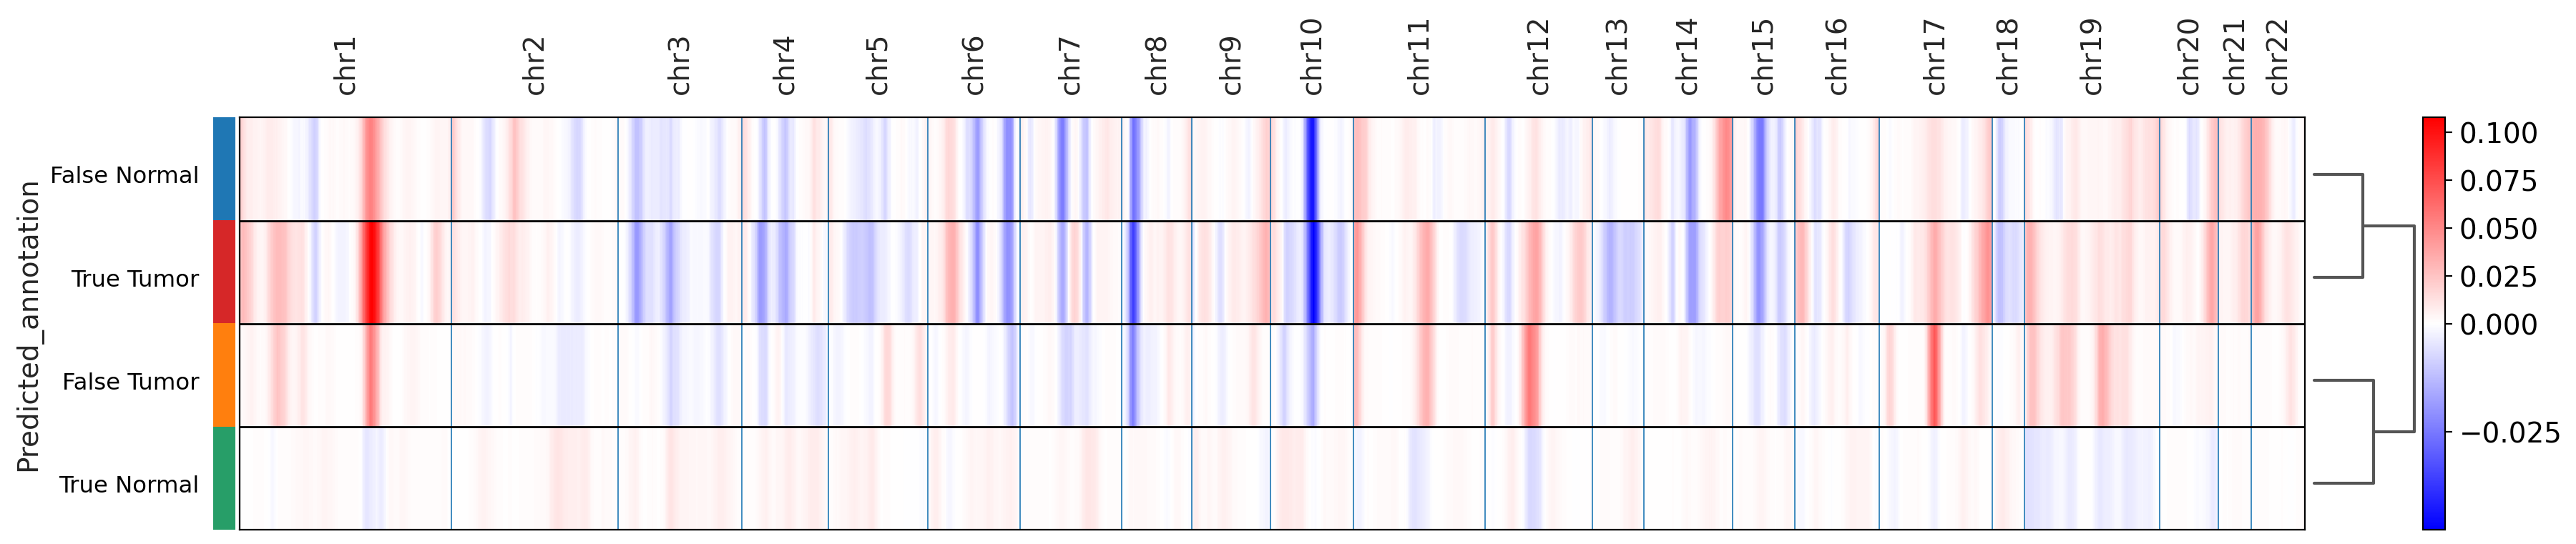

In [39]:
zdict = cnv.pl.chromosome_heatmap_summary(adata, groupby="Predicted_annotation", dendrogram=True, show=False, figsize=(20,4))
plt.savefig(f'./plot/infercnv_{prefix}_four_categories.heatmap.pdf', bbox_inches='tight')

In [40]:
cnv.tl.leiden(adata, resolution=1.5)
cnv.tl.cnv_score(adata)

In [41]:
pairs = [('True Normal','False Tumor'),('True Tumor','False Normal')]

INFO:fontTools.subset:maxp pruned
INFO:fontTools.subset:cmap pruned
INFO:fontTools.subset:kern dropped
INFO:fontTools.subset:post pruned
INFO:fontTools.subset:FFTM dropped
INFO:fontTools.subset:GPOS pruned
INFO:fontTools.subset:GSUB pruned
INFO:fontTools.subset:name pruned
INFO:fontTools.subset:glyf pruned
INFO:fontTools.subset:Added gid0 to subset
INFO:fontTools.subset:Added first four glyphs to subset
INFO:fontTools.subset:Closing glyph list over 'GSUB': 30 glyphs before
INFO:fontTools.subset:Glyph names: ['.notdef', '.null', 'F', 'N', 'P', 'T', 'a', 'asterisk', 'c', 'd', 'e', 'five', 'i', 'l', 'm', 'n', 'nonmarkingreturn', 'o', 'one', 'period', 'r', 's', 'space', 't', 'three', 'two', 'u', 'underscore', 'v', 'zero']
INFO:fontTools.subset:Glyph IDs:   [0, 1, 2, 3, 13, 17, 19, 20, 21, 22, 24, 41, 49, 51, 55, 66, 68, 70, 71, 72, 76, 79, 80, 81, 82, 85, 86, 87, 88, 89]
INFO:fontTools.subset:Closed glyph list over 'GSUB': 30 glyphs after
INFO:fontTools.subset:Glyph names: ['.notdef', '.nu

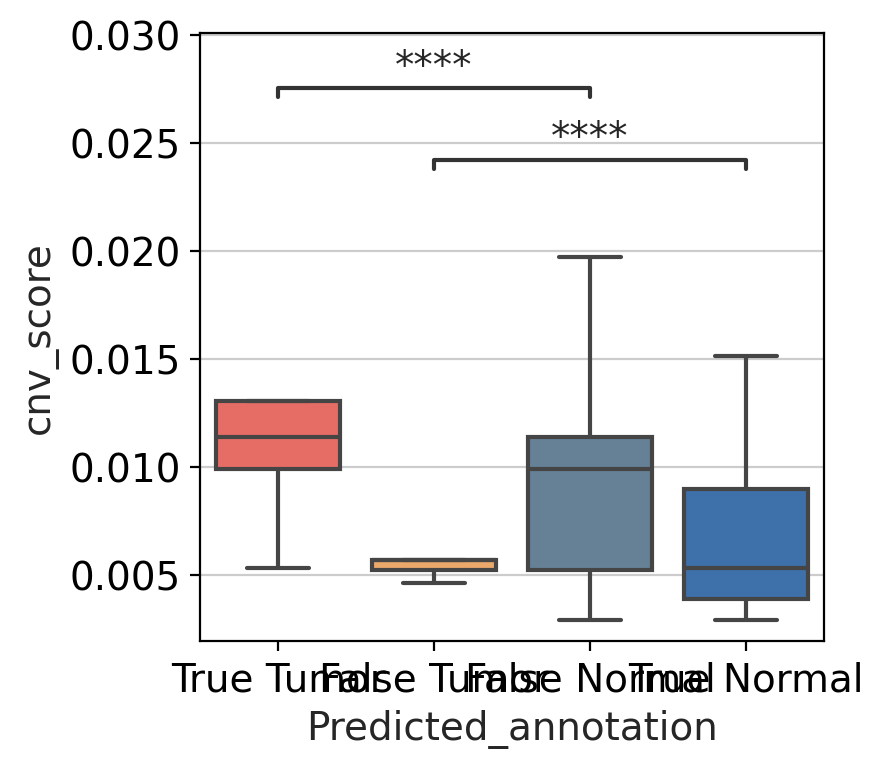

In [42]:
plt.figure(figsize=(4,4))

ax21 = plt.subplot(111)
ax = sns.boxplot(data=adata.obs, x="Predicted_annotation", y='cnv_score', ax=ax21, fliersize=0, palette=['#fc5a50','#ffa756','#5e819d','#2c6fbb'], 
                 order=['True Tumor','False Tumor','False Normal','True Normal'])
annot = Annotator(ax, pairs, data=adata.obs, x="Predicted_annotation", y='cnv_score', order=['True Tumor','False Tumor','False Normal','True Normal'], hide_non_significant=True)
annot.configure(test='t-test_ind', text_format='star', verbose=0)
annot.apply_test()
_ = annot.annotate()
plt.savefig(f'./plot/cnv_score_{prefix}_four_categories.boxplot.pdf', bbox_inches='tight')

In [43]:
prefix = 'LC3'
adata = test_adata_dict[prefix]
sc.pp.normalize_total(adata, target_sum=1e4)
sc.pp.log1p(adata)

In [44]:
overlap_genes = list(set(adata.var_names) & set(ref_df['gene_name']))
print(len(overlap_genes))

spec_gene_dict = {
    'GOLGA8M':'1957781','MATR3':'801455','ARMCX5-GPRASP2':'2699327','LINC01238':'353646','TMSB15B':'2700269','HSPA14':'1341394',
    'LINC01505':'1265639','CYB561D2':'493710','GGT1':'2621672','TBCE':'129239'
}

unique_ref_df = ref_df[ref_df['gene_name'].isin(ref_df['gene_name'].value_counts()[ref_df['gene_name'].value_counts()==1].index)]
double_ref_df = ref_df[ref_df['gene_name'].isin(ref_df['gene_name'].value_counts()[ref_df['gene_name'].value_counts()==2].index)]
unique_double_ref_df = double_ref_df.loc[[int(x) for x in list(spec_gene_dict.values())]]

concat_ref_df = pd.concat([unique_ref_df,unique_double_ref_df])
concat_ref_df.index = concat_ref_df['gene_name'].tolist()

concat_ref_df = concat_ref_df.loc[overlap_genes]

adata = adata[:,overlap_genes].copy()

adata.var['chromosome'] = concat_ref_df['Chromosome'].tolist()
adata.var['end'] = concat_ref_df['Start'].tolist()
adata.var['start'] = concat_ref_df['End'].tolist()

20667


In [45]:
cnv.tl.infercnv(
        adata,
        reference_key='Raw_annotation',
        reference_cat=['Normal'],
        window_size=250,
        exclude_chromosomes=['chrX','chrY'],
        chunksize=1000,
        n_jobs=20,
        inplace=True
)

cnv.tl.pca(adata)
cnv.pp.neighbors(adata)

  0%|          | 0/65 [00:00<?, ?it/s]

/mnt/home/qnyu/miniconda3/envs/scverse/lib/python3.10/site-packages/anndata/_core/anndata.py:117: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)
... storing 'Predicted_annotation' as categorical


         Falling back to preprocessing with `sc.pp.pca` and default params.
categories: False Normal, False Tumor, True Normal, etc.
var_group_labels: chr1, chr2, chr3, etc.


/mnt/home/qnyu/miniconda3/envs/scverse/lib/python3.10/site-packages/scanpy/tools/_dendrogram.py:133: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  mean_df = rep_df.groupby(level=0).mean()
INFO:fontTools.subset:maxp pruned
INFO:fontTools.subset:cmap pruned
INFO:fontTools.subset:kern dropped
INFO:fontTools.subset:post pruned
INFO:fontTools.subset:FFTM dropped
INFO:fontTools.subset:GPOS pruned
INFO:fontTools.subset:GSUB pruned
INFO:fontTools.subset:name pruned
INFO:fontTools.subset:glyf pruned
INFO:fontTools.subset:Added gid0 to subset
INFO:fontTools.subset:Added first four glyphs to subset
INFO:fontTools.subset:Closing glyph list over 'GSUB': 35 glyphs before
INFO:fontTools.subset:Glyph names: ['.notdef', '.null', 'F', 'N', 'P', 'T', 'a', 'c', 'd', 'e', 'eight', 'five', 'four', 'h', 'i', 'l', 'm', '

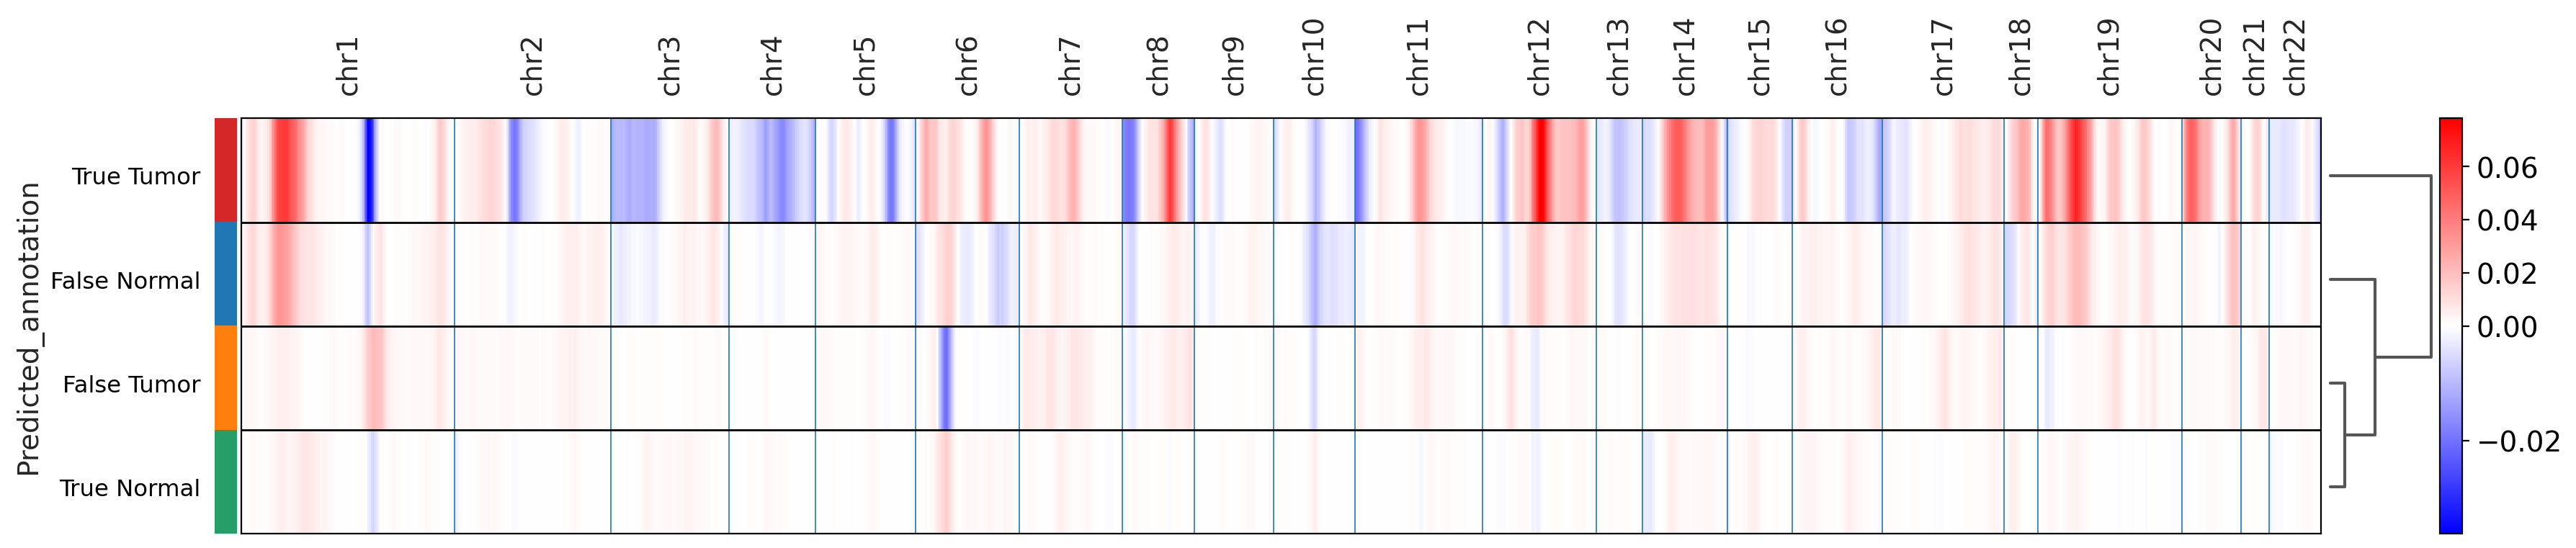

In [46]:
zdict = cnv.pl.chromosome_heatmap_summary(adata, groupby="Predicted_annotation", dendrogram=True, show=False, figsize=(20,4))
plt.savefig(f'./plot/infercnv_{prefix}_four_categories.heatmap.pdf', bbox_inches='tight')

In [47]:
cnv.tl.leiden(adata, resolution=1.5)
cnv.tl.cnv_score(adata)

In [48]:
pairs = [('True Normal','False Tumor'),('True Tumor','False Normal')]

INFO:fontTools.subset:maxp pruned
INFO:fontTools.subset:cmap pruned
INFO:fontTools.subset:kern dropped
INFO:fontTools.subset:post pruned
INFO:fontTools.subset:FFTM dropped
INFO:fontTools.subset:GPOS pruned
INFO:fontTools.subset:GSUB pruned
INFO:fontTools.subset:name pruned
INFO:fontTools.subset:glyf pruned
INFO:fontTools.subset:Added gid0 to subset
INFO:fontTools.subset:Added first four glyphs to subset
INFO:fontTools.subset:Closing glyph list over 'GSUB': 29 glyphs before
INFO:fontTools.subset:Glyph names: ['.notdef', '.null', 'F', 'N', 'P', 'T', 'a', 'asterisk', 'c', 'd', 'e', 'five', 'i', 'l', 'm', 'n', 'nonmarkingreturn', 'o', 'one', 'period', 'r', 's', 'space', 't', 'two', 'u', 'underscore', 'v', 'zero']
INFO:fontTools.subset:Glyph IDs:   [0, 1, 2, 3, 13, 17, 19, 20, 21, 24, 41, 49, 51, 55, 66, 68, 70, 71, 72, 76, 79, 80, 81, 82, 85, 86, 87, 88, 89]
INFO:fontTools.subset:Closed glyph list over 'GSUB': 29 glyphs after
INFO:fontTools.subset:Glyph names: ['.notdef', '.null', 'F', 'N'

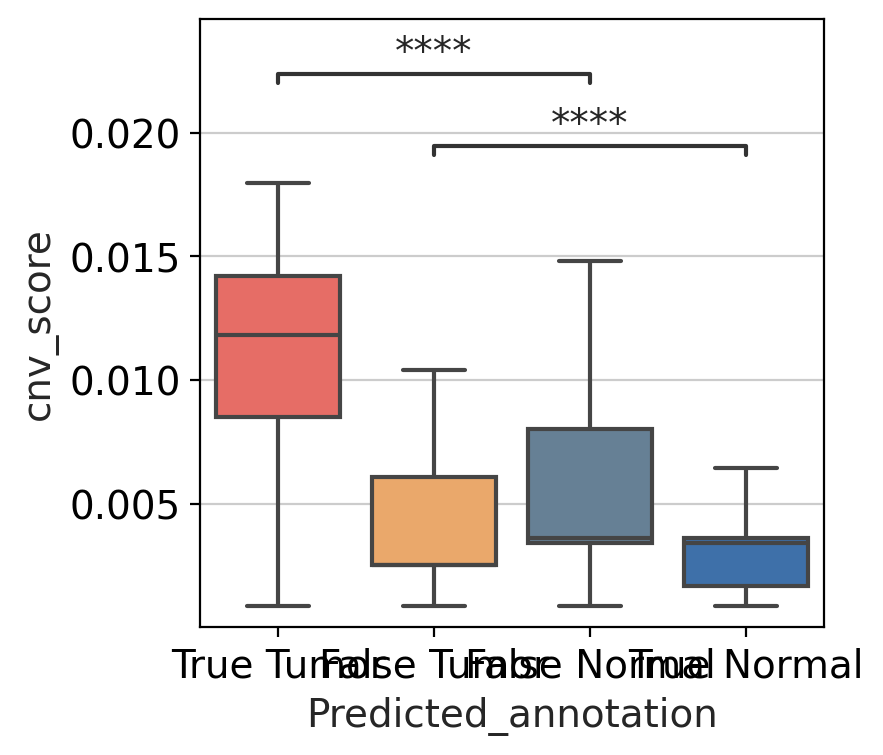

In [49]:
plt.figure(figsize=(4,4))

ax21 = plt.subplot(111)
ax = sns.boxplot(data=adata.obs, x="Predicted_annotation", y='cnv_score', ax=ax21, fliersize=0, palette=['#fc5a50','#ffa756','#5e819d','#2c6fbb'], 
                 order=['True Tumor','False Tumor','False Normal','True Normal'])
annot = Annotator(ax, pairs, data=adata.obs, x="Predicted_annotation", y='cnv_score', order=['True Tumor','False Tumor','False Normal','True Normal'], hide_non_significant=True)
annot.configure(test='t-test_ind', text_format='star', verbose=0)
annot.apply_test()
_ = annot.annotate()
plt.savefig(f'./plot/cnv_score_{prefix}_four_categories.boxplot.pdf', bbox_inches='tight')

In [50]:
prefix = 'CRC1'
adata = test_adata_dict[prefix]
sc.pp.normalize_total(adata, target_sum=1e4)
sc.pp.log1p(adata)

In [51]:
overlap_genes = list(set(adata.var_names) & set(ref_df['gene_name']))
print(len(overlap_genes))

spec_gene_dict = {
    'GOLGA8M':'1957781','MATR3':'801455','ARMCX5-GPRASP2':'2699327','LINC01238':'353646','TMSB15B':'2700269','HSPA14':'1341394',
    'LINC01505':'1265639','CYB561D2':'493710','GGT1':'2621672','TBCE':'129239'
}

unique_ref_df = ref_df[ref_df['gene_name'].isin(ref_df['gene_name'].value_counts()[ref_df['gene_name'].value_counts()==1].index)]
double_ref_df = ref_df[ref_df['gene_name'].isin(ref_df['gene_name'].value_counts()[ref_df['gene_name'].value_counts()==2].index)]
unique_double_ref_df = double_ref_df.loc[[int(x) for x in list(spec_gene_dict.values())]]

concat_ref_df = pd.concat([unique_ref_df,unique_double_ref_df])
concat_ref_df.index = concat_ref_df['gene_name'].tolist()

concat_ref_df = concat_ref_df.loc[overlap_genes]

adata = adata[:,overlap_genes].copy()

adata.var['chromosome'] = concat_ref_df['Chromosome'].tolist()
adata.var['end'] = concat_ref_df['Start'].tolist()
adata.var['start'] = concat_ref_df['End'].tolist()

21834


In [52]:
cnv.tl.infercnv(
        adata,
        reference_key='Raw_annotation',
        reference_cat=['Normal'],
        window_size=250,
        exclude_chromosomes=['chrX','chrY'],
        chunksize=1000,
        n_jobs=20,
        inplace=True
)

cnv.tl.pca(adata)
cnv.pp.neighbors(adata)

  0%|          | 0/58 [00:00<?, ?it/s]

/mnt/home/qnyu/miniconda3/envs/scverse/lib/python3.10/site-packages/anndata/_core/anndata.py:117: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)
... storing 'Predicted_annotation' as categorical


         Falling back to preprocessing with `sc.pp.pca` and default params.
categories: False Normal, False Tumor, True Normal, etc.
var_group_labels: chr1, chr2, chr3, etc.


/mnt/home/qnyu/miniconda3/envs/scverse/lib/python3.10/site-packages/scanpy/tools/_dendrogram.py:133: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  mean_df = rep_df.groupby(level=0).mean()
INFO:fontTools.subset:maxp pruned
INFO:fontTools.subset:cmap pruned
INFO:fontTools.subset:kern dropped
INFO:fontTools.subset:post pruned
INFO:fontTools.subset:FFTM dropped
INFO:fontTools.subset:GPOS pruned
INFO:fontTools.subset:GSUB pruned
INFO:fontTools.subset:name pruned
INFO:fontTools.subset:glyf pruned
INFO:fontTools.subset:Added gid0 to subset
INFO:fontTools.subset:Added first four glyphs to subset
INFO:fontTools.subset:Closing glyph list over 'GSUB': 35 glyphs before
INFO:fontTools.subset:Glyph names: ['.notdef', '.null', 'F', 'N', 'P', 'T', 'a', 'c', 'd', 'e', 'eight', 'five', 'four', 'h', 'i', 'l', 'm', '

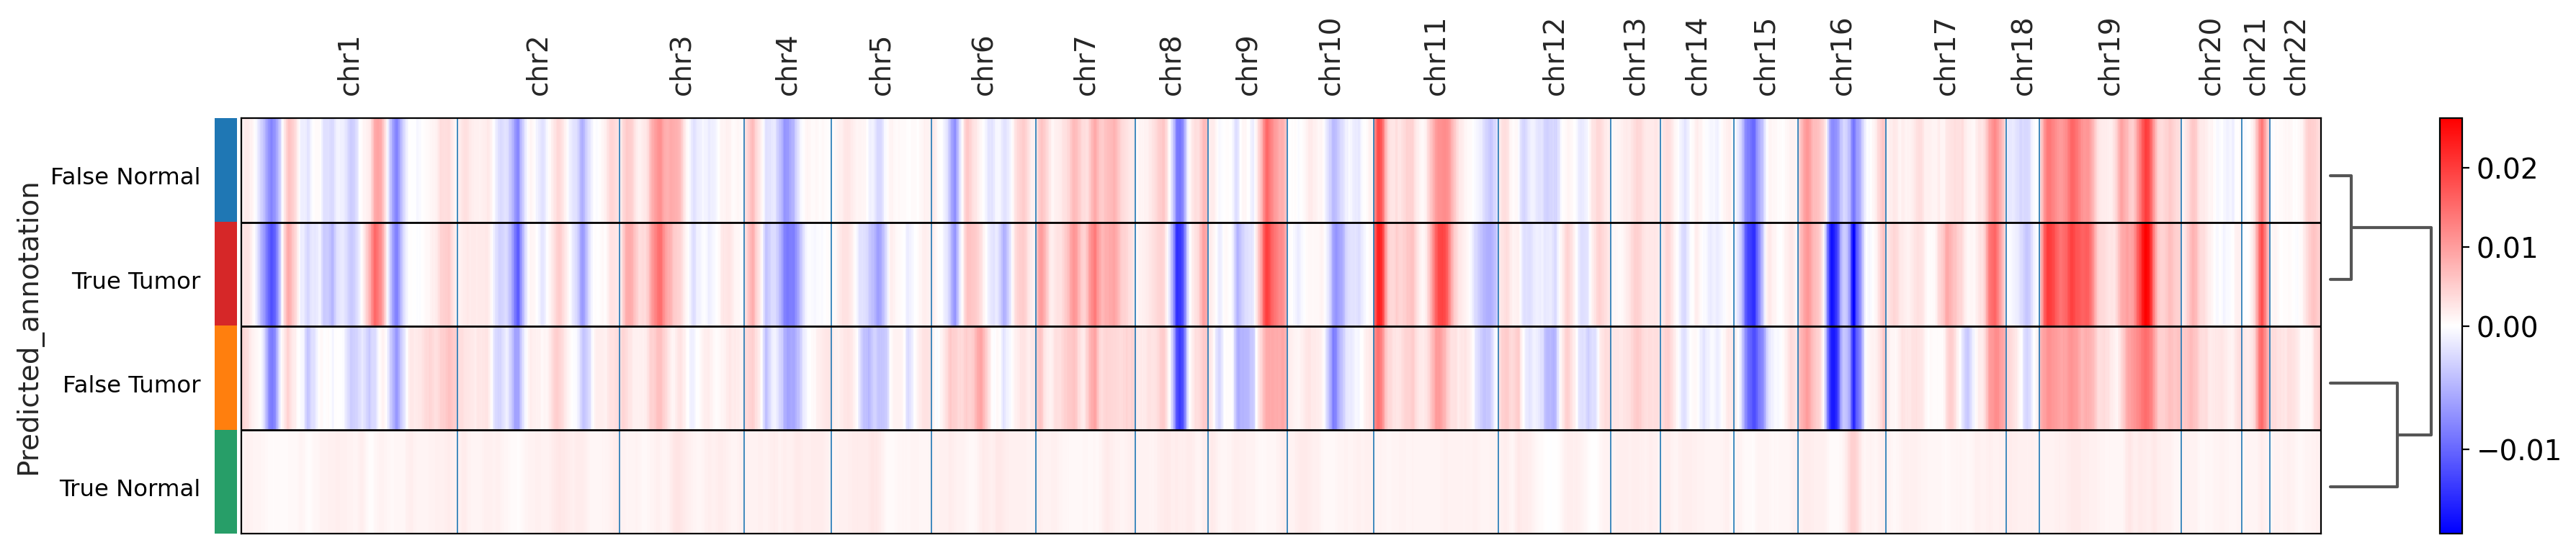

In [53]:
zdict = cnv.pl.chromosome_heatmap_summary(adata, groupby="Predicted_annotation", dendrogram=True, show=False, figsize=(20,4))
plt.savefig(f'./plot/infercnv_{prefix}_four_categories.heatmap.pdf', bbox_inches='tight')

In [54]:
cnv.tl.leiden(adata, resolution=1.5)
cnv.tl.cnv_score(adata)

In [55]:
pairs = [('True Normal','False Tumor'),('True Tumor','False Normal')]

INFO:fontTools.subset:maxp pruned
INFO:fontTools.subset:cmap pruned
INFO:fontTools.subset:kern dropped
INFO:fontTools.subset:post pruned
INFO:fontTools.subset:FFTM dropped
INFO:fontTools.subset:GPOS pruned
INFO:fontTools.subset:GSUB pruned
INFO:fontTools.subset:name pruned
INFO:fontTools.subset:glyf pruned
INFO:fontTools.subset:Added gid0 to subset
INFO:fontTools.subset:Added first four glyphs to subset
INFO:fontTools.subset:Closing glyph list over 'GSUB': 32 glyphs before
INFO:fontTools.subset:Glyph names: ['.notdef', '.null', 'F', 'N', 'P', 'T', 'a', 'asterisk', 'c', 'd', 'e', 'eight', 'i', 'l', 'm', 'n', 'nine', 'nonmarkingreturn', 'o', 'one', 'period', 'r', 's', 'seven', 'six', 'space', 't', 'two', 'u', 'underscore', 'v', 'zero']
INFO:fontTools.subset:Glyph IDs:   [0, 1, 2, 3, 13, 17, 19, 20, 21, 25, 26, 27, 28, 41, 49, 51, 55, 66, 68, 70, 71, 72, 76, 79, 80, 81, 82, 85, 86, 87, 88, 89]
INFO:fontTools.subset:Closed glyph list over 'GSUB': 32 glyphs after
INFO:fontTools.subset:Glyph

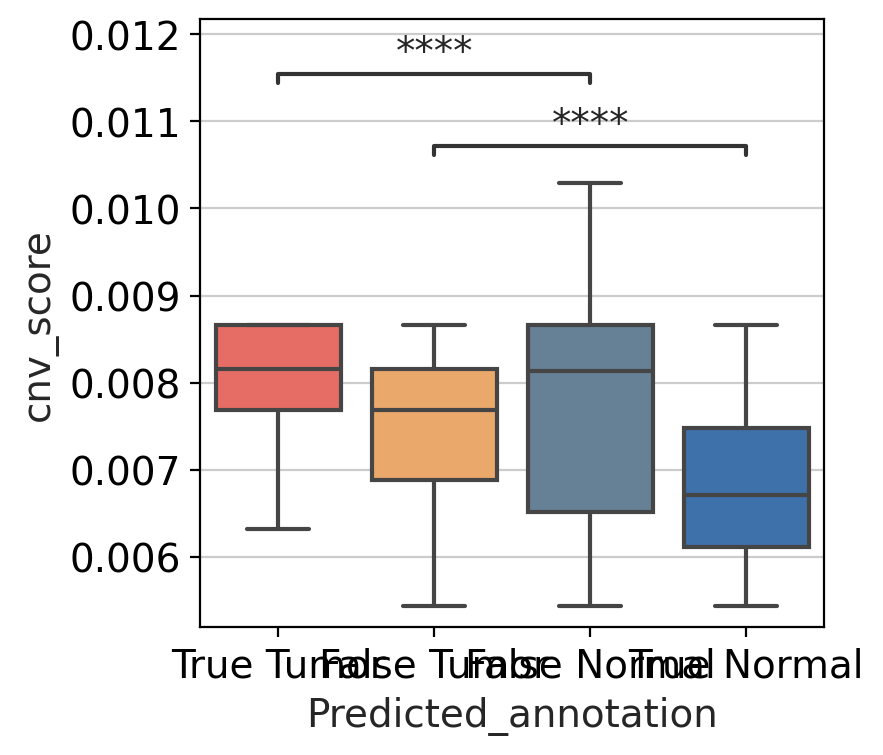

In [56]:
plt.figure(figsize=(4,4))

ax21 = plt.subplot(111)
ax = sns.boxplot(data=adata.obs, x="Predicted_annotation", y='cnv_score', ax=ax21, fliersize=0, palette=['#fc5a50','#ffa756','#5e819d','#2c6fbb'], 
                 order=['True Tumor','False Tumor','False Normal','True Normal'])
annot = Annotator(ax, pairs, data=adata.obs, x="Predicted_annotation", y='cnv_score', order=['True Tumor','False Tumor','False Normal','True Normal'], hide_non_significant=True)
annot.configure(test='t-test_ind', text_format='star', verbose=0)
annot.apply_test()
_ = annot.annotate()
plt.savefig(f'./plot/cnv_score_{prefix}_four_categories.boxplot.pdf', bbox_inches='tight')

In [57]:
prefix = 'CRC2'
adata = test_adata_dict[prefix]
sc.pp.normalize_total(adata, target_sum=1e4)
sc.pp.log1p(adata)

In [58]:
overlap_genes = list(set(adata.var_names) & set(ref_df['gene_name']))
print(len(overlap_genes))

spec_gene_dict = {
    'GOLGA8M':'1957781','MATR3':'801455','ARMCX5-GPRASP2':'2699327','LINC01238':'353646','TMSB15B':'2700269','HSPA14':'1341394',
    'LINC01505':'1265639','CYB561D2':'493710','GGT1':'2621672','TBCE':'129239'
}

unique_ref_df = ref_df[ref_df['gene_name'].isin(ref_df['gene_name'].value_counts()[ref_df['gene_name'].value_counts()==1].index)]
double_ref_df = ref_df[ref_df['gene_name'].isin(ref_df['gene_name'].value_counts()[ref_df['gene_name'].value_counts()==2].index)]
unique_double_ref_df = double_ref_df.loc[[int(x) for x in list(spec_gene_dict.values())]]

concat_ref_df = pd.concat([unique_ref_df,unique_double_ref_df])
concat_ref_df.index = concat_ref_df['gene_name'].tolist()

concat_ref_df = concat_ref_df.loc[overlap_genes]

adata = adata[:,overlap_genes].copy()

adata.var['chromosome'] = concat_ref_df['Chromosome'].tolist()
adata.var['end'] = concat_ref_df['Start'].tolist()
adata.var['start'] = concat_ref_df['End'].tolist()

21919


In [59]:
cnv.tl.infercnv(
        adata,
        reference_key='Raw_annotation',
        reference_cat=['Normal'],
        window_size=250,
        exclude_chromosomes=['chrX','chrY'],
        chunksize=1000,
        n_jobs=20,
        inplace=True
)

cnv.tl.pca(adata)
cnv.pp.neighbors(adata)

  0%|          | 0/7 [00:00<?, ?it/s]

/mnt/home/qnyu/miniconda3/envs/scverse/lib/python3.10/site-packages/anndata/_core/anndata.py:117: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)
... storing 'Predicted_annotation' as categorical


         Falling back to preprocessing with `sc.pp.pca` and default params.
categories: False Normal, False Tumor, True Normal, etc.
var_group_labels: chr1, chr2, chr3, etc.


/mnt/home/qnyu/miniconda3/envs/scverse/lib/python3.10/site-packages/scanpy/tools/_dendrogram.py:133: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  mean_df = rep_df.groupby(level=0).mean()
INFO:fontTools.subset:maxp pruned
INFO:fontTools.subset:cmap pruned
INFO:fontTools.subset:kern dropped
INFO:fontTools.subset:post pruned
INFO:fontTools.subset:FFTM dropped
INFO:fontTools.subset:GPOS pruned
INFO:fontTools.subset:GSUB pruned
INFO:fontTools.subset:name pruned
INFO:fontTools.subset:glyf pruned
INFO:fontTools.subset:Added gid0 to subset
INFO:fontTools.subset:Added first four glyphs to subset
INFO:fontTools.subset:Closing glyph list over 'GSUB': 35 glyphs before
INFO:fontTools.subset:Glyph names: ['.notdef', '.null', 'F', 'N', 'P', 'T', 'a', 'c', 'd', 'e', 'eight', 'five', 'four', 'h', 'i', 'l', 'm', '

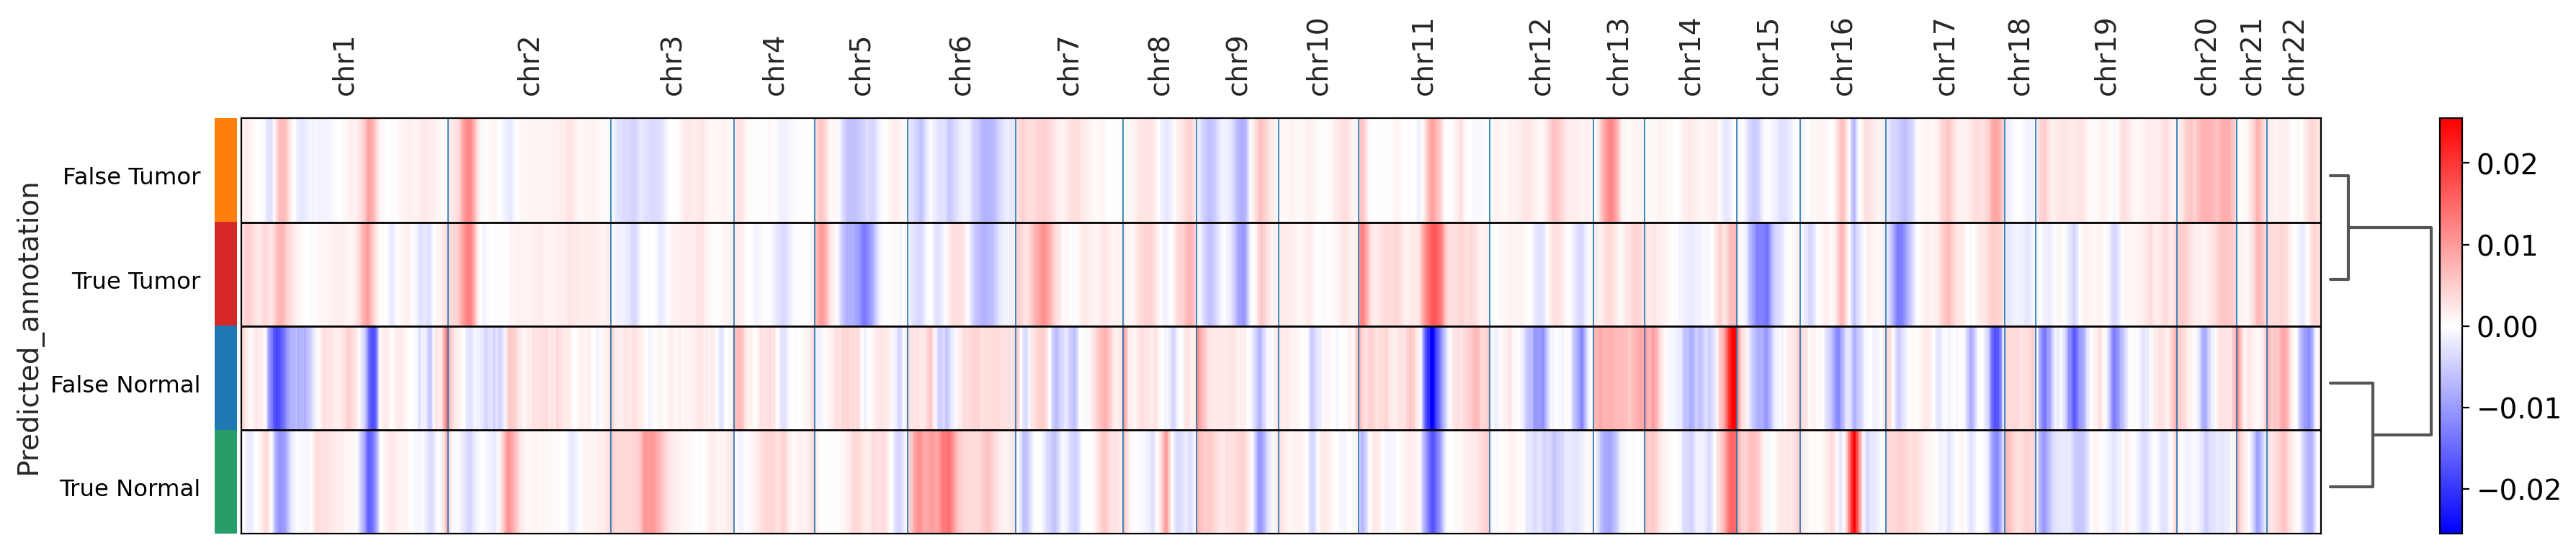

In [60]:
zdict = cnv.pl.chromosome_heatmap_summary(adata, groupby="Predicted_annotation", dendrogram=True, show=False, figsize=(20,4))
plt.savefig(f'./plot/infercnv_{prefix}_four_categories.heatmap.pdf', bbox_inches='tight')

In [61]:
cnv.tl.leiden(adata, resolution=1.5)
cnv.tl.cnv_score(adata)

In [62]:
pairs = [('True Normal','False Tumor'),('True Tumor','False Normal')]

INFO:fontTools.subset:maxp pruned
INFO:fontTools.subset:cmap pruned
INFO:fontTools.subset:kern dropped
INFO:fontTools.subset:post pruned
INFO:fontTools.subset:FFTM dropped
INFO:fontTools.subset:GPOS pruned
INFO:fontTools.subset:GSUB pruned
INFO:fontTools.subset:name pruned
INFO:fontTools.subset:glyf pruned
INFO:fontTools.subset:Added gid0 to subset
INFO:fontTools.subset:Added first four glyphs to subset
INFO:fontTools.subset:Closing glyph list over 'GSUB': 29 glyphs before
INFO:fontTools.subset:Glyph names: ['.notdef', '.null', 'F', 'N', 'P', 'T', 'a', 'asterisk', 'c', 'd', 'e', 'five', 'i', 'l', 'm', 'n', 'nonmarkingreturn', 'o', 'one', 'period', 'r', 's', 'space', 't', 'two', 'u', 'underscore', 'v', 'zero']
INFO:fontTools.subset:Glyph IDs:   [0, 1, 2, 3, 13, 17, 19, 20, 21, 24, 41, 49, 51, 55, 66, 68, 70, 71, 72, 76, 79, 80, 81, 82, 85, 86, 87, 88, 89]
INFO:fontTools.subset:Closed glyph list over 'GSUB': 29 glyphs after
INFO:fontTools.subset:Glyph names: ['.notdef', '.null', 'F', 'N'

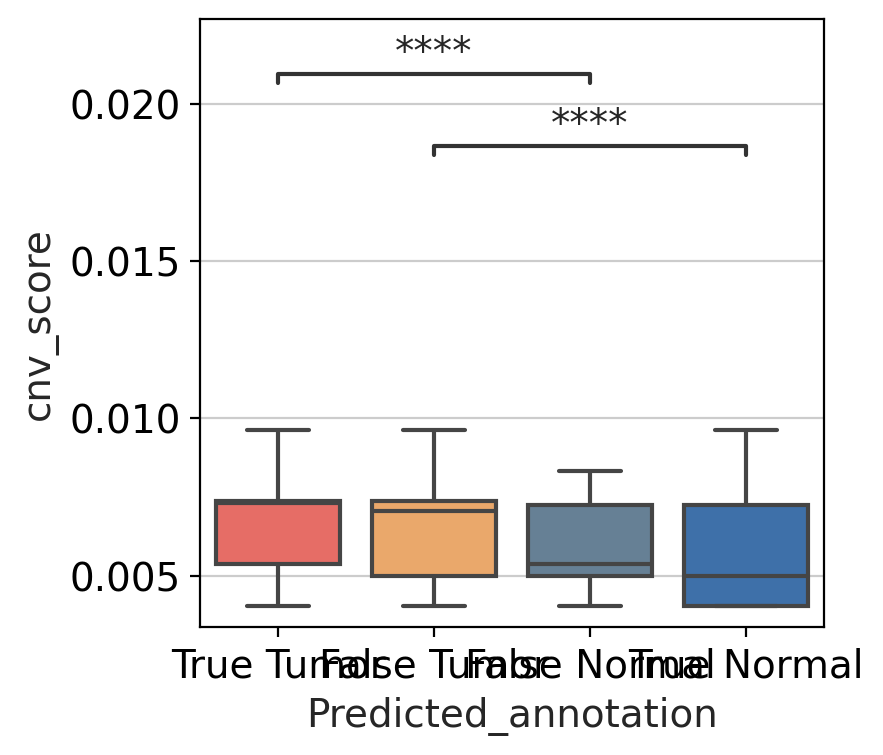

In [63]:
plt.figure(figsize=(4,4))

ax21 = plt.subplot(111)
ax = sns.boxplot(data=adata.obs, x="Predicted_annotation", y='cnv_score', ax=ax21, fliersize=0, palette=['#fc5a50','#ffa756','#5e819d','#2c6fbb'], 
                 order=['True Tumor','False Tumor','False Normal','True Normal'])
annot = Annotator(ax, pairs, data=adata.obs, x="Predicted_annotation", y='cnv_score', order=['True Tumor','False Tumor','False Normal','True Normal'], hide_non_significant=True)
annot.configure(test='t-test_ind', text_format='star', verbose=0)
annot.apply_test()
_ = annot.annotate()
plt.savefig(f'./plot/cnv_score_{prefix}_four_categories.boxplot.pdf', bbox_inches='tight')

In [81]:
prefix = 'LC3'
adata = test_adata_dict[prefix]

In [82]:
col1 = 'Predicted_annotation'
col2 = 'disease'
count_df = adata.obs.groupby([col1, col2]).size().to_frame('size').reset_index().pivot(index=col1, columns=col2, values='size')

/tmp/ipykernel_93941/2491439834.py:3: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  count_df = adata.obs.groupby([col1, col2]).size().to_frame('size').reset_index().pivot(index=col1, columns=col2, values='size')


In [83]:
prop_df = count_df.divide(count_df.sum(axis=1), axis=0)

In [84]:
prop_df = prop_df.loc[['True Tumor','False Tumor','False Normal','True Normal']]

In [86]:
prop_df.columns.tolist()

['lung adenocarcinoma', 'normal', 'small cell lung carcinoma']

INFO:fontTools.subset:maxp pruned
INFO:fontTools.subset:cmap pruned
INFO:fontTools.subset:kern dropped
INFO:fontTools.subset:post pruned
INFO:fontTools.subset:FFTM dropped
INFO:fontTools.subset:GPOS pruned
INFO:fontTools.subset:GSUB pruned
INFO:fontTools.subset:name pruned
INFO:fontTools.subset:glyf pruned
INFO:fontTools.subset:Added gid0 to subset
INFO:fontTools.subset:Added first four glyphs to subset
INFO:fontTools.subset:Closing glyph list over 'GSUB': 32 glyphs before
INFO:fontTools.subset:Glyph names: ['.notdef', '.null', 'F', 'N', 'P', 'T', 'a', 'c', 'd', 'e', 'five', 'four', 'g', 'i', 'l', 'm', 'n', 'nine', 'nonmarkingreturn', 'o', 'one', 'period', 'r', 's', 'seven', 'six', 'space', 't', 'three', 'u', 'underscore', 'zero']
INFO:fontTools.subset:Glyph IDs:   [0, 1, 2, 3, 17, 19, 20, 22, 23, 24, 25, 26, 28, 41, 49, 51, 55, 66, 68, 70, 71, 72, 74, 76, 79, 80, 81, 82, 85, 86, 87, 88]
INFO:fontTools.subset:Closed glyph list over 'GSUB': 32 glyphs after
INFO:fontTools.subset:Glyph na

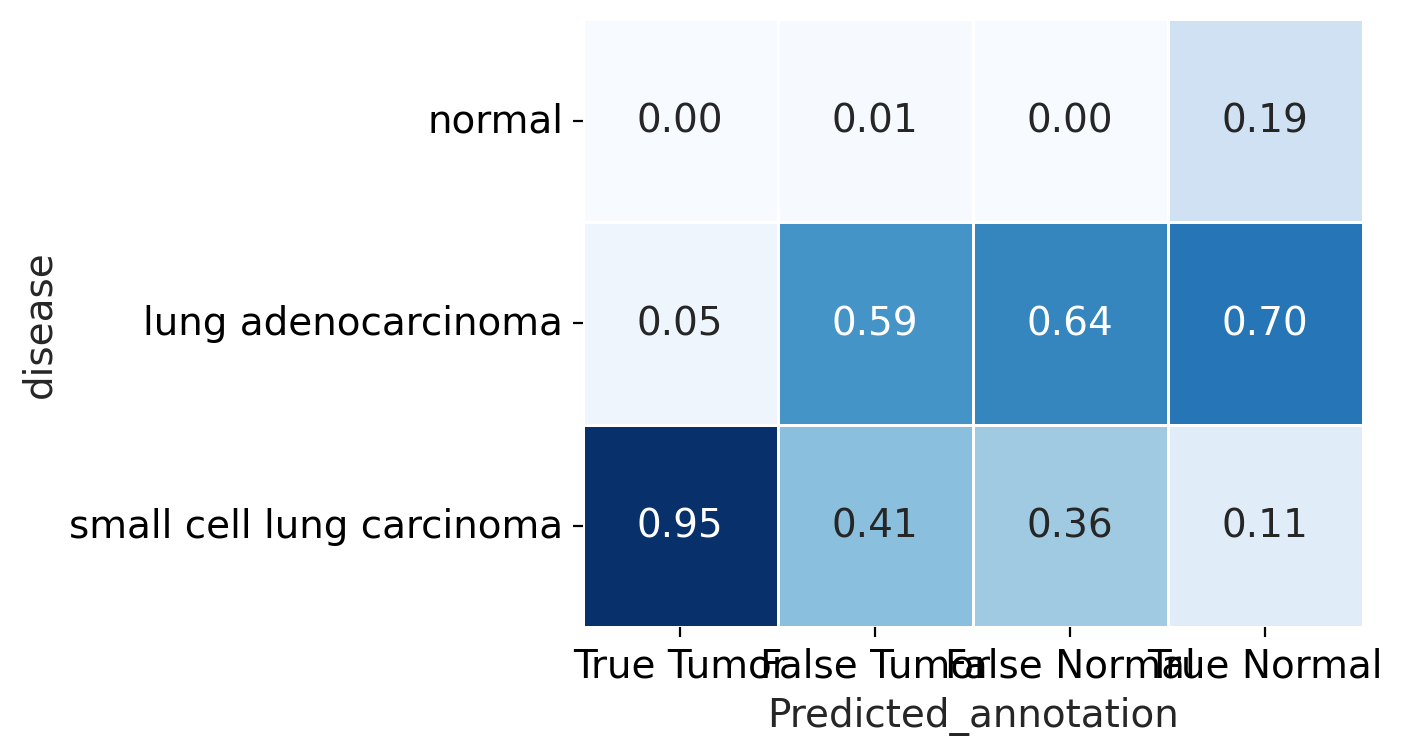

In [87]:
plt.figure(figsize=(5,4))
ax21 = plt.subplot(111)
sns.heatmap(prop_df.T.loc[['normal', 'lung adenocarcinoma', 'small cell lung carcinoma']], annot=True, fmt='.2f', cmap='Blues', yticklabels=True, cbar=False, ax=ax21, 
            linewidth=1)
_ = plt.xticks(rotation=0)
_ = plt.yticks(rotation=0)
plt.savefig(f'./plot/sample_proportion_{prefix}_four_categories.heatmap.pdf', bbox_inches='tight')

In [88]:
prefix = 'CRC1'
adata = test_adata_dict[prefix]

In [89]:
col1 = 'Predicted_annotation'
col2 = 'disease'
count_df = adata.obs.groupby([col1, col2]).size().to_frame('size').reset_index().pivot(index=col1, columns=col2, values='size')

/tmp/ipykernel_93941/2491439834.py:3: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  count_df = adata.obs.groupby([col1, col2]).size().to_frame('size').reset_index().pivot(index=col1, columns=col2, values='size')


In [90]:
prop_df = count_df.divide(count_df.sum(axis=1), axis=0)

In [91]:
prop_df = prop_df.loc[['True Tumor','False Tumor','False Normal','True Normal']]

In [92]:
prop_df.columns.tolist()

['colon sessile serrated adenoma/polyp',
 'colorectal cancer',
 'hyperplastic polyp',
 'normal',
 'tubular adenoma',
 'tubulovillous adenoma']

INFO:fontTools.subset:maxp pruned
INFO:fontTools.subset:cmap pruned
INFO:fontTools.subset:kern dropped
INFO:fontTools.subset:post pruned
INFO:fontTools.subset:FFTM dropped
INFO:fontTools.subset:GPOS pruned
INFO:fontTools.subset:GSUB pruned
INFO:fontTools.subset:name pruned
INFO:fontTools.subset:glyf pruned
INFO:fontTools.subset:Added gid0 to subset
INFO:fontTools.subset:Added first four glyphs to subset
INFO:fontTools.subset:Closing glyph list over 'GSUB': 38 glyphs before
INFO:fontTools.subset:Glyph names: ['.notdef', '.null', 'F', 'N', 'P', 'T', 'a', 'b', 'c', 'd', 'e', 'eight', 'five', 'h', 'i', 'l', 'm', 'n', 'nine', 'nonmarkingreturn', 'o', 'one', 'p', 'period', 'r', 's', 'seven', 'six', 'slash', 'space', 't', 'three', 'two', 'u', 'underscore', 'v', 'y', 'zero']
INFO:fontTools.subset:Glyph IDs:   [0, 1, 2, 3, 17, 18, 19, 20, 21, 22, 24, 25, 26, 27, 28, 41, 49, 51, 55, 66, 68, 69, 70, 71, 72, 75, 76, 79, 80, 81, 82, 83, 85, 86, 87, 88, 89, 92]
INFO:fontTools.subset:Closed glyph lis

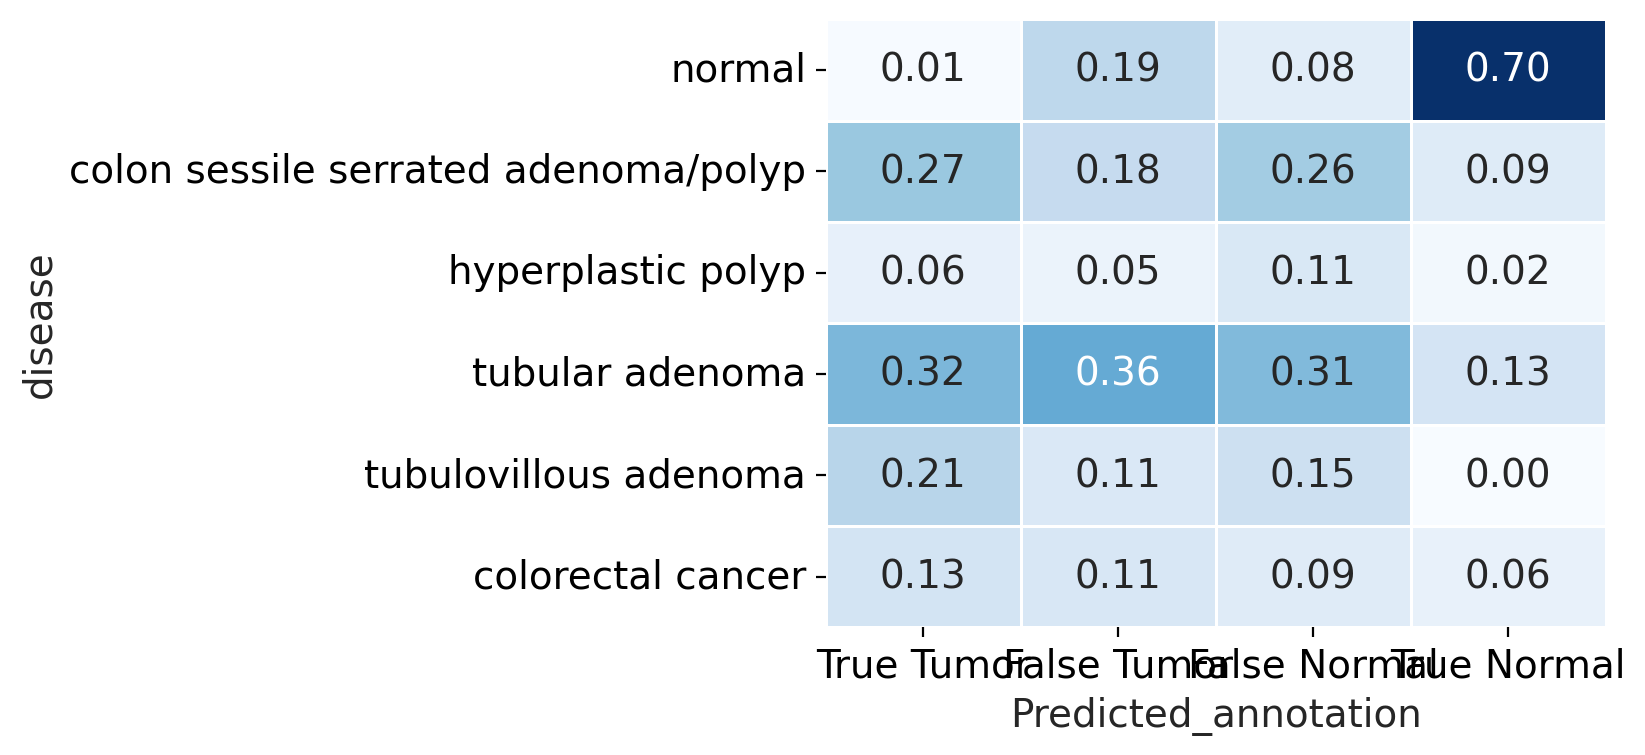

In [95]:
plt.figure(figsize=(5,4))
ax21 = plt.subplot(111)
sns.heatmap(prop_df.T.loc[['normal','colon sessile serrated adenoma/polyp','hyperplastic polyp','tubular adenoma','tubulovillous adenoma','colorectal cancer']], 
            annot=True, fmt='.2f', cmap='Blues', yticklabels=True, cbar=False, ax=ax21, linewidth=1)
_ = plt.xticks(rotation=0)
_ = plt.yticks(rotation=0)
plt.savefig(f'./plot/sample_proportion_{prefix}_four_categories.heatmap.pdf', bbox_inches='tight')